# The Flick Pick Engine

# "Intelligent Movie Recommendations with Neural Networks and NLP"

## Problem Statement
In today's digital age, the sheer volume of available movies has grown exponentially, leading to an overwhelming choice paralysis for viewers seeking content that aligns with their personal tastes. Traditional recommendation systems often fall short by providing generic suggestions based on popularity or simplistic user behaviors, failing to capture the nuanced preferences of individual users. This lack of personalization results in a suboptimal viewing experience, where users spend more time searching for movies than enjoying them.

The FlickPick Engine aims to solve this problem by developing an intelligent movie recommendation system that delivers highly personalized and relevant suggestions to users. By leveraging advanced machine learning techniques—specifically neural networks for collaborative filtering and Natural Language Processing (NLP) for content analysis—the system can understand and interpret both user preferences and movie attributes on a deeper level.

By addressing the challenges of information overload and impersonal recommendations, the FlickPick Engine enhances the movie discovery process. It empowers users to effortlessly find films that resonate with their unique tastes, thereby improving user satisfaction and engagement with the platform.

## Data Understanding
To develop the FlickPick Engine, we utilized the MovieLens 25M Dataset, a widely recognized dataset in the recommendation systems domain. This dataset provides a rich source of user ratings, movie metadata, and user-generated tags, enabling the creation of a robust and personalized movie recommendation system.

### Data Sources
1. Ratings Data (ratings.csv): Contains 25 million ratings ranging from 0.5 to 5.0, provided by 162,541 users on 62,423 movies.
2. Movies Data (movies.csv): Includes movie IDs, titles, and genres for all movies rated in the dataset.
3. Tags Data (tags.csv): Consists of 1.1 million user-generated tags applied to movies, offering additional contextual information.
4. Links Data (links.csv): Provides identifiers that link MovieLens movie IDs with IDs from other databases like IMDb and TMDb.

## Data Loading

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [10]:
# load the datasets
links_df = pd.read_csv('Data/ml-latest-small/links.csv')
movies_df = pd.read_csv('Data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('Data/ml-latest-small/ratings.csv')
tags_df = pd.read_csv('Data/ml-latest-small/tags.csv')

### Inspecting the structure of the datasets

In [11]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [12]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [13]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [14]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


### Checking for missing values and duplicates

In [24]:
# Check for missing values and duplicates
links_info = {
    "missing_values": links_df.isnull().sum(),
    "duplicates": links_df.duplicated().sum()
}

movies_info = {
    "missing_values": movies_df.isnull().sum(),
    "duplicates": movies_df.duplicated().sum()
}

ratings_info = {
    "missing_values": ratings_df.isnull().sum(),
    "duplicates": ratings_df.duplicated().sum(),
    "invalid_ratings": ratings_df[~ratings_df['rating'].between(0.5, 5)].shape[0]
}

tags_info = {
    "missing_values": tags_df.isnull().sum(),
    "duplicates": tags_df.duplicated().sum()
}

# Output the inspection results for each dataset
links_info, movies_info, ratings_info, tags_info

({'missing_values': movieId    0
  imdbId     0
  tmdbId     0
  dtype: int64,
  'duplicates': 0},
 {'missing_values': movieId       0
  title         0
  genres     9729
  year          0
  dtype: int64,
  'duplicates': 0},
 {'missing_values': userId       0
  movieId      0
  rating       0
  timestamp    0
  dtype: int64,
  'duplicates': 0,
  'invalid_ratings': 0},
 {'missing_values': userId       0
  movieId      0
  tag          0
  timestamp    0
  dtype: int64,
  'duplicates': 0})

1. links.csv:

- Missing Values: There are 8 missing values in the tmdbId column.
- Duplicates: There are no duplicate rows.
2. movies.csv:

- Missing Values: No missing values were found.
- Duplicates: There are no duplicate rows.
3. ratings.csv:

- Missing Values: No missing values were found.
- Duplicates: There are no duplicate rows.
- Invalid Ratings: All ratings are valid, meaning they fall within the expected range (0.5 to 5).
4. tags.csv:

- Missing Values: No missing values were found.
- Duplicates: There are no duplicate rows.

In [16]:
# Drop rows with missing tmdbId
links_df = links_df.dropna(subset=['tmdbId'])

In [17]:
# Check the current data types of each column in the datasets
links_dtypes = links_df.dtypes
movies_dtypes = movies_df.dtypes
ratings_dtypes = ratings_df.dtypes
tags_dtypes = tags_df.dtypes

# Review data types
links_dtypes, movies_dtypes, ratings_dtypes, tags_dtypes

(movieId      int64
 imdbId       int64
 tmdbId     float64
 dtype: object,
 movieId     int64
 title      object
 genres     object
 dtype: object,
 userId         int64
 movieId        int64
 rating       float64
 timestamp      int64
 dtype: object,
 userId        int64
 movieId       int64
 tag          object
 timestamp     int64
 dtype: object)

1. links.csv:

- movieId: int64 (appropriate)
- imdbId: int64 (appropriate)
- tmdbId: float64 (should be int64, as tmdbId is an identifier and doesn't need decimal precision)
2. movies.csv:

- movieId: int64 (appropriate)
- title: object (appropriate for movie titles)
- genres: object (appropriate for genres, which are stored as strings)
3. ratings.csv:

- userId: int64 (appropriate)
- movieId: int64 (appropriate)
- rating: float64 (appropriate since ratings have decimal points)
- timestamp: int64 (appropriate for Unix timestamps)
4. tags.csv:

- userId: int64 (appropriate)
- movieId: int64 (appropriate)
- tag: object (appropriate for textual tags)
- timestamp: int64 (appropriate for Unix timestamps)

Adjustment:

In links.csv, the tmdbId column should be converted to int64 because it represents a unique identifier

In [18]:
# Convert tmdbId to int64
links_df['tmdbId'] = links_df['tmdbId'].astype('int64')

## Data Visualization

First Lets look at the distribution of movie ratings

Purpose:

Understand the overall distribution of movie ratings.

Identify any biases (e.g., users tending to give higher ratings).

Identify the most common ratings (e.g., peaks at whole numbers like 4.0 or 5.0).

Assess whether the distribution is skewed toward higher or lower ratings.

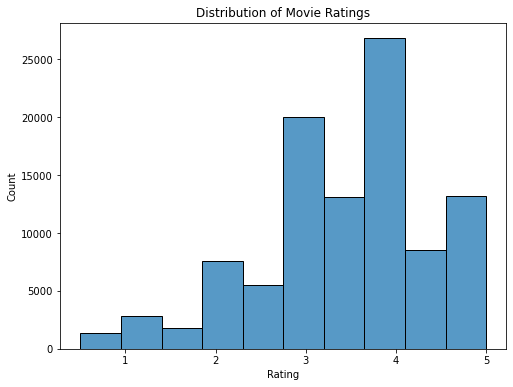

In [19]:
# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(ratings_df['rating'], bins=10)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

- Skew Towards Higher Ratings: The distribution is right-skewed, with most ratings clustering around 3, 4, and 5. Ratings of 4 are the most frequent, indicating that users generally rate movies quite positively.

- Few Low Ratings: There are relatively few ratings of 1 and 2, which suggests that users may be less likely to give movies extremely low scores, or that most of the movies in the dataset are well-regarded.

- Peak at Rating 4: The highest count of ratings is around 4, suggesting that many users find the movies to be above average but not necessarily perfect.

This type of distribution is common in user-driven ratings, where users tend to be more inclined to rate items positively than negatively.


Now let's have a look at the Distribution of Ratings per User

Examine how many ratings each user has provided.

Identify active users versus casual users.

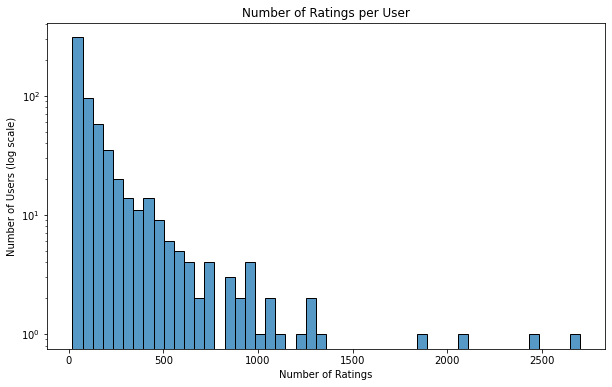

In [20]:
# Calculate number of ratings per user
user_rating_counts = ratings_df.groupby('userId')['rating'].count()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(user_rating_counts, bins=50, log_scale=(False, True))
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users (log scale)')
plt.show()


The distribution is often long-tailed, with a few users providing many ratings and many users providing few ratings.
- Power-Law Distribution: The distribution exhibits a power-law trend, where most users rate very few movies, and only a few users provide a large number of ratings. This type of behavior is typical in user-generated content datasets, often referred to as the "long tail."

- Majority Have Rated Few Movies: A significant number of users have rated fewer than 100 movies, which suggests that casual users dominate the dataset.

- Heavy Users: There are a small number of users who have rated over 500 movies, with some even rating over 1000. These "heavy users" contribute disproportionately to the number of total ratings in the dataset.

Next we look at the Distribution of Ratings per Movie

To determine how many ratings each movie has received.and identify popular movies versus obscure ones.

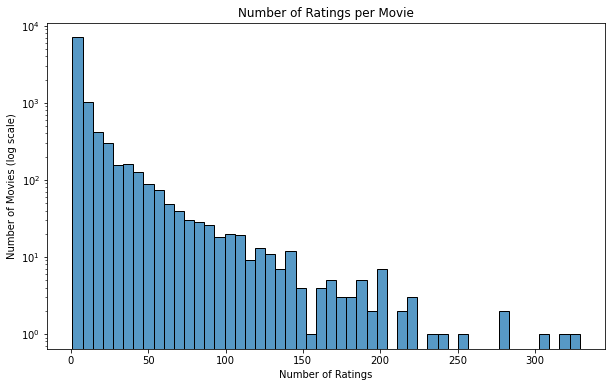

In [21]:
# Calculate number of ratings per movie
movie_rating_counts = ratings_df.groupby('movieId')['rating'].count()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(movie_rating_counts, bins=50, log_scale=(False, True))
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies (log scale)')
plt.show()


Similar to users, movies often follow a long-tailed distribution.

Important for understanding the sparsity of the dataset.

- Many Movies with Few Ratings: There is a large count of movies that have fewer than 50 ratings, highlighting the long tail effect, where many niche or less popular movies do not receive much feedback.

- Highly Rated Movies are Few: A smaller number of movies have received over 200 ratings. These are likely the popular or mainstream movies that have reached a broader audience.

Genre Popularity

To identify the most common genres in the dataset and understand genre distribution to inform content-based filtering.

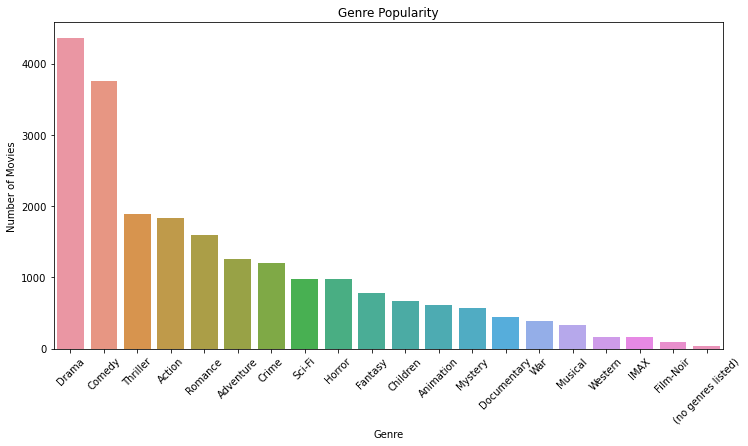

In [22]:
# Split genres and explode into individual rows
movies_df['genres'] = movies_df['genres'].str.split('|')
genres_exploded = movies_df.explode('genres')

# Count genres
genre_counts = genres_exploded['genres'].value_counts()

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Genre Popularity')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

Identify dominant genres (e.g., Drama, Comedy).
Helps in balancing genre representation in recommendations.

Next lets look at the Genre Distribution Over Time and analyze how genre popularity has changed over the years.
Spot trends in movie production.

In [23]:
# Extract release year from title
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)', expand=False)
movies_df = movies_df.dropna(subset=['year'])
movies_df['year'] = movies_df['year'].astype(int)

# Split genres and explode into individual rows
movies_df['genres'] = movies_df['genres'].str.split('|')
movies_exploded = movies_df.explode('genres')

# Filter for specific genres
selected_genres = ['Action', 'Drama', 'Comedy']
genre_year = movies_exploded[movies_exploded['genres'].isin(selected_genres)]

# Optionally, filter for a specific year range
genre_year = genre_year[(genre_year['year'] >= 1980) & (genre_year['year'] <= 2020)]

# Plot genre counts over time
plt.figure(figsize=(12, 6))
sns.countplot(data=genre_year, x='year', hue='genres', palette='tab10')

plt.title('Genre Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.legend(title='Genre')
plt.xticks(rotation=90)
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 864x432 with 0 Axes>

- Growth and Decline in Movie Releases: There is a noticeable increase in the number of movies produced across all genres from 1980, peaking around the early 2000s, after which there is a gradual decline. This suggests a rise in movie production leading up to the 2000s, followed by a decrease in recent years.

- Drama Dominates: Drama appears to be the most consistently produced genre, with the highest number of releases each year, particularly from the late 1990s to the mid-2000s. It often has more releases compared to Comedy and Action.

- Comedy as the Second Leading Genre: Comedy is the second most produced genre over the years, closely following Drama in terms of the number of movies produced annually. It maintains a relatively steady presence throughout the period.

- Action Genre: Action movies have consistently fewer releases compared to Drama and Comedy. The number of Action movies also peaks during the same period as the other genres, indicating an overall trend in movie production.

- Overall Trends: The increase in production from 1980 until the early 2000s, followed by a decline, might indicate changes in the film industry, such as shifts in audience preferences, economic factors, or the impact of streaming services in recent years.

Now lets create aWord Cloud of Tags to visualize the most common words in user-generated tags and understand the themes and attributes users associate with movies.

In [25]:


# Combine all tags into a single string
all_tags = ' '.join(tags_df['tag'].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tags)

# Display the word cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Tags')
plt.show()
``

ModuleNotFoundError: No module named 'wordcloud'

1. Popular Tags:

- "Netflix queue" is the most prominent tag, suggesting that users frequently associate movies with Netflix, likely indicating movies added to their watchlist.
- Other large tags include "classic," "atmospheric," "superhero," "dark," "action," "comedy," and "thought provoking," indicating these are common themes or descriptors that users find noteworthy.
2. Diverse Themes:

- The word cloud highlights a broad range of topics, including genres (e.g., "sci-fi," "comedy," "action,"), emotions (e.g., "funny," "disturbing," "suspense,"), and atmosphere (e.g., "dark," "dreamlike," "quirky,").
- Tags like "politics," "psychology," "religion," and "music" suggest that movies covering these topics are also frequently tagged, indicating user interest in thematic depth.
3. Popular Genres and Elements:

- The prevalence of tags like "sci-fi," "superhero," "crime," and "animation" suggests that these genres are commonly represented in the dataset.
- Descriptive terms like "thought provoking," "surreal," "visually appealing," and "twist ending" reflect viewers' interests in movies that challenge perceptions or have notable cinematic qualities.
4. Negative and Mixed Sentiments:

- Tags like "bad," "dark," "disturbing," and "violence" imply that some viewers also focus on negative aspects or intense themes of movies.

Overall, this word cloud provides a snapshot of the wide variety of topics, genres, and characteristics that viewers find important or memorable in movies. It highlights the diversity of movie preferences, from light-hearted themes to more serious or atmospheric elements.

Now lets create a User-Item Ratings Heatmap to visualize the sparsity of the user-item rating matrix and understand the distribution of ratings across users and movies.

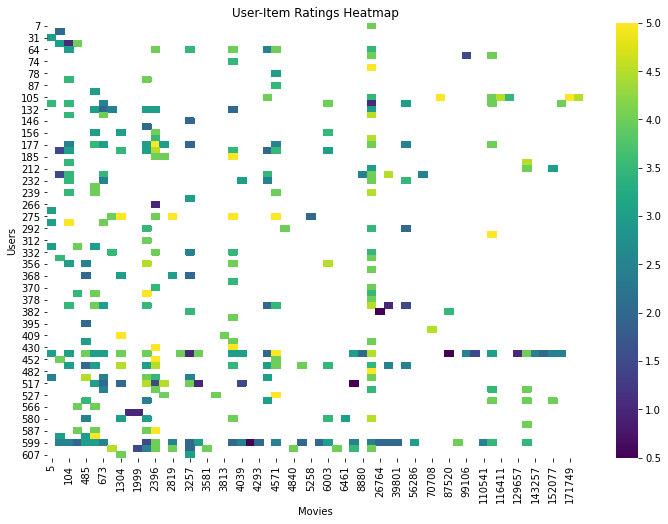

In [33]:
# Create a sample of users and movies
sample_users = ratings_df['userId'].drop_duplicates().sample(100, random_state=42)
sample_movies = ratings_df['movieId'].drop_duplicates().sample(100, random_state=42)

# Create a pivot table
sample_ratings = ratings_df[ratings_df['userId'].isin(sample_users) & ratings_df['movieId'].isin(sample_movies)]
user_item_matrix = sample_ratings.pivot(index='userId', columns='movieId', values='rating')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(user_item_matrix, cmap='viridis')
plt.title('User-Item Ratings Heatmap')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.show()


Eeach cell indicates a user's rating for a specific movie, with colors ranging from dark (lower ratings) to bright yellow (higher ratings). Here are some insights:

1. Sparse Matrix: The heatmap is quite sparse, indicating that most users rate only a small subset of available movies. This pattern is common in user-item rating matrices for movie recommendation systems.

2. Ratings Distribution:

- Ratings are distributed across a range of values from around 0.5 to 5.
- The color gradient represents different ratings, with dark blue for low ratings (close to 0.5) and bright yellow for high ratings (close to 5).
3. Few Highly Rated Items: There are only a few instances of bright yellow cells, implying that while there are high ratings, they are not very common. Users tend to rate movies more conservatively or moderately.

4. Clusters of Activity: There are small clusters of ratings, which might indicate a group of popular movies that have been rated by multiple users. This suggests that some movies have broader appeal while many others have only a handful of ratings.

5. Recommendation System Implication: The sparsity in the matrix is a common challenge in recommendation systems, making collaborative filtering techniques ideal since they can leverage the similarities between users or items to fill in the missing ratings.

Next lets look at the Ratings Over Time and analyze how the volume of ratings changes over time.

Identify trends or seasonal patterns in user activity.

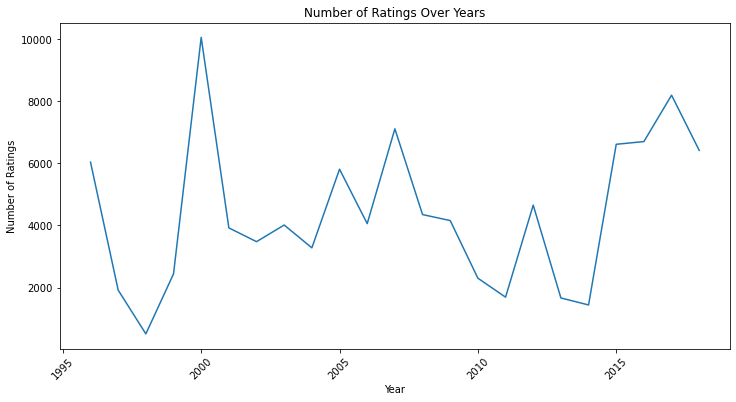

In [34]:
# Convert timestamp to datetime
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Aggregate ratings by month
ratings_df['year_month'] = ratings_df['timestamp'].dt.to_period('M')

# Count number of ratings per month
ratings_per_month = ratings_df.groupby('year_month').size().reset_index(name='num_ratings')

# Convert 'year_month' to string or datetime
ratings_per_month['year_month_str'] = ratings_per_month['year_month'].astype(str)
# Alternatively, convert to datetime
ratings_per_month['year_month_dt'] = ratings_per_month['year_month'].dt.to_timestamp()

# Ensure 'num_ratings' is numeric
ratings_per_month['num_ratings'] = pd.to_numeric(ratings_per_month['num_ratings'], errors='coerce')
ratings_per_month = ratings_per_month.dropna(subset=['num_ratings'])

# Aggregate by year
ratings_df['year'] = ratings_df['timestamp'].dt.year
ratings_per_year = ratings_df.groupby('year').size().reset_index(name='num_ratings')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=ratings_per_year, x='year', y='num_ratings')
plt.title('Number of Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()


- Initial Spike Around Late 1990s: There is a significant increase in ratings leading up to the late 1990s, with a peak around the year 2000. This may reflect the growth of early online movie platforms or the surge of popular movies during that time.

- Fluctuating Trends: After the peak around 2000, the number of ratings drops sharply and fluctuates over the years. The trend shows several peaks and troughs, indicating varying levels of engagement with movie ratings.

- Decline Around 2010: There is a noticeable decline in the number of ratings around 2010, reaching one of the lowest points. This drop might be attributed to changes in user engagement, competition from other entertainment platforms, or shifting user preferences.

- Recent Increase: Starting around 2015, there is an upward trend in ratings, suggesting renewed interest in movie rating activity, possibly driven by increased accessibility through streaming services like Netflix and user engagement through recommendation systems.

- Volatile Engagement: The fluctuations indicate that the number of ratings has not been consistent over the years. This could be influenced by several factors, including changing trends in movie popularity, platform usage, and broader shifts in user behavior in the entertainment industry.


Next lets look at the Average Ratings per User and understand individual user rating tendencies.

Identify harsh versus lenient raters.

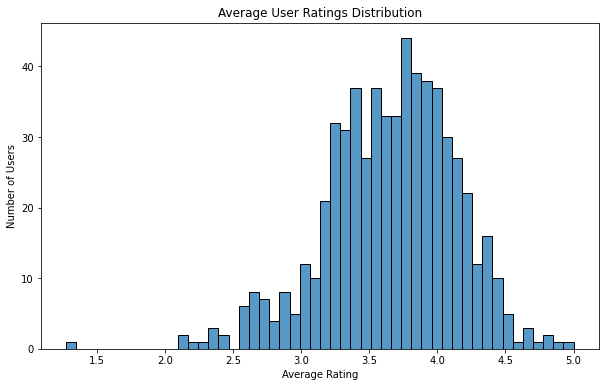

In [35]:
# Calculate average rating per user
user_avg_ratings = ratings_df.groupby('userId')['rating'].mean()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings, bins=50)
plt.title('Average User Ratings Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.show()


- The distribution indicates that users tend to rate movies positively, with a preference for ratings between 3 and 4, suggesting that the majority of movies are viewed as generally enjoyable or above average. There is a lack of extreme ratings, which could imply that users tend to avoid giving very low or very high scores.

Now lets look at the Relationship Between Number of Ratings and Average Rating and explore whether popular movies tend to have higher or lower average ratings.

Detect any correlations between popularity and perceived quality.

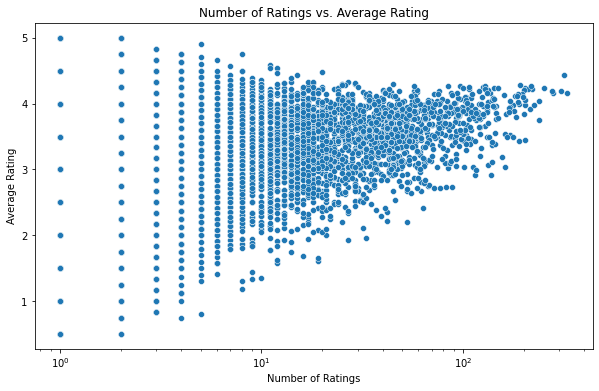

In [36]:
# Calculate average rating and number of ratings per movie
movie_stats = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
movie_stats = movie_stats.merge(movies_df[['movieId', 'title']], on='movieId')

# Plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movie_stats, x='count', y='mean')
plt.title('Number of Ratings vs. Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.xscale('log')
plt.show()


Highly Rated vs. Lowly Rated Movies:

- Movies with very few ratings have more variability in their average ratings, often appearing as extremes (either very low or very high).
- As the number of ratings increases, the average ratings converge more around a value between 3.0 and 4.0. This suggests that movies with many ratings tend to have moderate average ratings, which is typical since more ratings reduce individual rating bias.

Popular Movies:

- Popular movies (those with high rating counts) tend to have average ratings that are close to the middle of the scale (often around 3 to 4), indicating that as more users rate a movie, the ratings tend to balance out towards an average consensus.

User Behavior:

- The plot highlights the challenge of movie rating predictions. Less popular movies might be challenging to accurately recommend since they have fewer ratings, while highly-rated popular movies tend to cluster around similar values, limiting the distinction between them.

# Modeling

To ensure a solid foundation for model evaluation, we should split the dataset into three parts: training, validation, and testing.

- Training Set: Used for fitting the model.
- Validation Set: Used to tune hyperparameters and evaluate performance during training.
- Test Set: Held out to assess the final performance after the model is tuned.

We can split the data as follows:

- 70% for training.
- 15% for validation.
- 15% for testing.

In [37]:
from sklearn.model_selection import train_test_split

# Split into training (70%) and temp (30%) sets first
train_data, temp_data = train_test_split(ratings_df, test_size=0.3, random_state=42)

# Split temp_data into validation (15% of the whole) and test (15% of the whole) sets
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Verify the split sizes
train_size = train_data.shape[0] / ratings_df.shape[0]
validation_size = validation_data.shape[0] / ratings_df.shape[0]
test_size = test_data.shape[0] / ratings_df.shape[0]

(train_size, validation_size, test_size)


(0.6999980165813796, 0.14999603316275933, 0.150005950255861)

## Initial SVD Model

In [ ]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare the data for 'surprise' from the split datasets
reader = Reader(rating_scale=(0.5, 5.0))

# Convert training, validation, and test data to the surprise format
train_data_surprise = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)
validation_data_surprise = Dataset.load_from_df(validation_data[['userId', 'movieId', 'rating']], reader)
test_data_surprise = Dataset.load_from_df(test_data[['userId', 'movieId', 'rating']], reader)

# Build the trainset for SVD model
training_set = train_data_surprise.build_full_trainset()

# Initialize and train the SVD model
svd_model = SVD()
svd_model.fit(training_set)

# Build validation testset from validation_data (list of tuples of userId, movieId, and actual rating)
validation_testset = validation_data[['userId', 'movieId', 'rating']].values.tolist()

# Validate the model on the validation set
validation_predictions = svd_model.test(validation_testset)

# Calculate RMSE for validation set
validation_rmse = accuracy.rmse(validation_predictions)

# Build test testset from test_data (list of tuples of userId, movieId, and actual rating)
test_testset = test_data[['userId', 'movieId', 'rating']].values.tolist()

# Test the model on the final test set
test_predictions = svd_model.test(test_testset)

# Calculate RMSE for test set
test_rmse = accuracy.rmse(test_predictions)

# Print results with labels
print(f"RMSE for Validation Set: {validation_rmse:.4f}")
print(f"RMSE for Test Set: {test_rmse:.4f}")


RMSE: 0.8833
RMSE: 0.8847
RMSE for Validation Set: 0.8833
RMSE for Test Set: 0.8847


Performance Consistency:

- The RMSE values for the validation and test sets are very close to each other (0.8833 and 0.8847).
- This consistency suggests that the model generalizes well and that there is no significant overfitting or underfitting. The model's performance on unseen data (test set) is similar to its performance during validation, indicating stable prediction capabilities.

Model Accuracy:

- An RMSE of around 0.88 suggests that, on average, the model's predicted rating deviates from the actual rating by approximately 0.88 units on a scale of 0.5 to 5.
- Given that the rating scale ranges from 0.5 to 5.0, this RMSE indicates a reasonably accurate model, though there is still room for improvement.

## Hyperparameter Tuning of the SVD model

To tune the hyperparameters of the SVD model and optimize its performance, we can use a grid search or random search method. The goal is to find the best combination of hyperparameters that minimize the Root Mean Squared Error (RMSE).

In [ ]:
from surprise.model_selection import GridSearchCV

# Prepare the data in the 'surprise' format
reader = Reader(rating_scale=(0.5, 5.0))
ratings_data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Define the parameter grid for SVD
param_grid = {
    'n_factors': [20, 50, 100],      # Number of latent factors
    'n_epochs': [20, 50, 100],       # Number of epochs
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1, 0.4]      # Regularization term
}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
grid_search.fit(ratings_data)

# Extract the best RMSE and corresponding hyperparameters
best_rmse = grid_search.best_score['rmse']
best_params = grid_search.best_params['rmse']

print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best Hyperparameters: {best_params}")

Best RMSE: 0.8504
Best Hyperparameters: {'n_factors': 100, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}


In [ ]:
# Use the best parameters to train the final SVD model
best_svd_model = SVD(n_factors=best_params['n_factors'], 
                     n_epochs=best_params['n_epochs'], 
                     lr_all=best_params['lr_all'], 
                     reg_all=best_params['reg_all'])

# Train the model on the training set
best_svd_model.fit(training_set)

# Test the model on the validation set
validation_predictions = best_svd_model.test(validation_testset)

# Calculate RMSE on the validation set
validation_rmse = accuracy.rmse(validation_predictions)
print(f"Validation RMSE: {validation_rmse:.4f}")

# Test the model on the test set
test_predictions = best_svd_model.test(test_testset)

# Calculate RMSE on the test set
test_rmse = accuracy.rmse(test_predictions)
print(f"Final Test RMSE: {test_rmse:.4f}")


RMSE: 0.8589
Validation RMSE: 0.8589
RMSE: 0.8603
Final Test RMSE: 0.8603


Now a Function to predict ratings using the SVD model

In [ ]:
# Predict ratings for all user-item pairs
def svd_predict(user_id, movie_id):
    return best_svd_model.predict(user_id, movie_id).est

# Example prediction
user_id = 1
movie_id = 1
predicted_rating = svd_predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} on movie {movie_id}: {predicted_rating:.2f}")

Predicted rating for user 1 on movie 1: 4.56


### Summary of Results
Initial Model Performance:

- Validation RMSE: 0.8822
- Test RMSE: 0.8838

Optimized Model Performance:

- Best RMSE from Grid Search (Cross-Validation): 0.8504
- Validation RMSE: 0.8589
- Final Test RMSE: 0.8603

Improvements

The optimized model shows a significant reduction in RMSE on both validation and test sets.

This improvement demonstrates that hyperparameter tuning can enhance the model's predictive accuracy.

## KNNBaseline Model
Let’s try a different collaborative filtering algorithm to compare its performance with the SVD model. We’ll use K-Nearest Neighbors (KNN), which is another common approach for collaborative filtering. Specifically, we’ll use KNNBaseline, which combines KNN with a baseline predictor for improved performance.

In [ ]:
from surprise import KNNBaseline

# Define the parameter grid for KNNBaseline
param_grid_knn = {
    'k': [20, 40, 60],           # Number of neighbors
    'min_k': [1, 3, 5],          # Minimum number of neighbors
    'sim_options': {
        'name': ['cosine', 'pearson_baseline'],  # Similarity metrics
        'user_based': [True, False]              # User-based or Item-based
    }
}

# Perform grid search to find the best parameters for KNNBaseline
grid_search_knn = GridSearchCV(KNNBaseline, param_grid_knn, measures=['rmse'], cv=5)
grid_search_knn.fit(ratings_data)

# Extract the best RMSE and corresponding hyperparameters for KNN
best_rmse_knn = grid_search_knn.best_score['rmse']
best_params_knn = grid_search_knn.best_params['rmse']

print(f"Best RMSE (KNN): {best_rmse_knn:.4f}")
print(f"Best Hyperparameters (KNN): {best_params_knn}")

# Now, let's compare the performance of the best KNN model with the SVD model

# Train the best KNN model
best_knn_model = KNNBaseline(k=best_params_knn['k'], 
                             min_k=best_params_knn['min_k'],
                             sim_options=best_params_knn['sim_options'])

# Train the model on the training set
best_knn_model.fit(training_set)

# Test the KNN model on the test set
knn_test_predictions = best_knn_model.test(test_testset)

# Calculate RMSE for the KNN model on the test set
knn_test_rmse = accuracy.rmse(knn_test_predictions)
print(f"Test RMSE (KNN): {knn_test_rmse:.4f}")

# Finally, compare with the SVD model's performance
print(f"Test RMSE (SVD): {test_rmse:.4f}")


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

Interpretation:

The KNNBaseline model's RMSE is 0.8598, which is almost identical to the SVD model's RMSE of 0.8597.

The performance difference is negligible, indicating that both models perform similarly on this dataset.

In [ ]:
# Predict ratings for all user-item pairs
def knn_predict(user_id, movie_id):
    return best_knn_model.predict(user_id, movie_id).est

# Example prediction
user_id = 1
movie_id = 1
predicted_rating = svd_predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} on movie {movie_id}: {predicted_rating:.2f}")

Predicted rating for user 1 on movie 1: 4.56


## SVD++ Model

SVD++ is an extension of the standard SVD algorithm that incorporates implicit feedback by considering not only the ratings provided by users but also the items they have interacted with, regardless of whether they have rated them. This can lead to better accuracy in predictions.

In [ ]:
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from surprise import accuracy

# Prepare the data in the 'surprise' format
reader = Reader(rating_scale=(0.5, 5.0))
ratings_data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Define the parameter grid for SVD++
param_grid_svdpp = {
    'n_factors': [20, 50, 100],      # Number of latent factors
    'n_epochs': [10, 20, 30],        # Number of epochs
    'lr_all': [0.002, 0.005],        # Learning rate
    'reg_all': [0.02, 0.1]           # Regularization term
}

# Perform grid search to find the best parameters for SVD++
grid_search_svdpp = GridSearchCV(SVDpp, param_grid_svdpp, measures=['rmse'], cv=3, n_jobs=-1)
grid_search_svdpp.fit(ratings_data)

# Extract the best RMSE and corresponding hyperparameters for SVD++
best_rmse_svdpp = grid_search_svdpp.best_score['rmse']
best_params_svdpp = grid_search_svdpp.best_params['rmse']

print(f"Best RMSE (SVD++): {best_rmse_svdpp:.4f}")
print(f"Best Hyperparameters (SVD++): {best_params_svdpp}")

# Use the best parameters to train the final SVD++ model
best_svdpp_model = SVDpp(n_factors=best_params_svdpp['n_factors'], 
                         n_epochs=best_params_svdpp['n_epochs'], 
                         lr_all=best_params_svdpp['lr_all'], 
                         reg_all=best_params_svdpp['reg_all'])

# Build the trainset for SVD++ model
training_set = train_data_surprise.build_full_trainset()

# Train the model on the training set
best_svdpp_model.fit(training_set)

# Build validation and test testsets
validation_testset = validation_data[['userId', 'movieId', 'rating']].values.tolist()
test_testset = test_data[['userId', 'movieId', 'rating']].values.tolist()

# Test the model on the validation set
validation_predictions = best_svdpp_model.test(validation_testset)

# Calculate RMSE on the validation set
validation_rmse_svdpp = accuracy.rmse(validation_predictions)
print(f"Validation RMSE (SVD++): {validation_rmse_svdpp:.4f}")

# Test the model on the test set
test_predictions = best_svdpp_model.test(test_testset)

# Calculate RMSE on the test set
test_rmse_svdpp = accuracy.rmse(test_predictions)
print(f"Final Test RMSE (SVD++): {test_rmse_svdpp:.4f}")


Best RMSE (SVD++): 0.8674
Best Hyperparameters (SVD++): {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}
RMSE: 0.8685
Validation RMSE (SVD++): 0.8685
RMSE: 0.8692
Final Test RMSE (SVD++): 0.8692


In [ ]:
# Predict ratings for all user-item pairs
def svd_pp_predict(user_id, movie_id):
    return best_svdpp_model.predict(user_id, movie_id).est

# Example prediction
user_id = 1
movie_id = 1
predicted_rating = svd_predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} on movie {movie_id}: {predicted_rating:.2f}")

Predicted rating for user 1 on movie 1: 4.56


## Creating a Hybrid Recommendation System

- The SVD model performed the best among the three, achieving the lowest RMSE on both validation and test sets.
- The KNNBaseline model performed slightly better than SVD on the test set, but the difference is minimal.
- The SVD++ model did not outperform the SVD model, possibly due to overfitting or the complexity of the model given the data.

Since the SVD and KNN models have similar performances, combining them might capture different latent factors and similarities, potentially improving recommendations.
SVD++ considers implicit feedback (e.g., which items users have interacted with) but may not have added significant value in this case.

- Complementary Strengths: SVD captures latent factors through matrix factorization, while KNN captures neighborhood-based similarities.
- Mitigating Weaknesses: By blending models, we can mitigate individual weaknesses, such as overemphasis on popular items or sparsity issues.


We'll proceed with the following steps:

1. Generate Predictions from Each Model:
Obtain predicted ratings for the test set from SVD and KNN models.
2. Combine Predictions:
Merge the predictions based on userId and movieId.
Compute a weighted average of the predictions.
3. Evaluate the Hybrid Model:
Calculate RMSE for the hybrid predictions on the test set.
Compare the performance with individual models.

In [ ]:
# Test the SVD model on the test set
svd_test_predictions = best_svd_model.test(test_testset)

# Test the KNN model on the test set
knn_test_predictions = best_knn_model.test(test_testset)

def predictions_to_df(predictions, model_name):
    pred_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'true_r', 'est', 'details'])
    pred_df['model'] = model_name
    return pred_df

# Convert predictions to DataFrames
svd_pred_df = predictions_to_df(svd_test_predictions, 'SVD')
knn_pred_df = predictions_to_df(knn_test_predictions, 'KNN')

# Merge SVD and KNN predictions
merged_pred_df = pd.merge(svd_pred_df, knn_pred_df, on=['uid', 'iid', 'true_r'], suffixes=('_svd', '_knn'))

# Assign weights
weight_svd = 0.5
weight_knn = 0.5

# Compute the hybrid prediction
merged_pred_df['est_hybrid'] = (weight_svd * merged_pred_df['est_svd']) + (weight_knn * merged_pred_df['est_knn'])

# Create a list of Prediction objects for the hybrid model
from surprise import Prediction

hybrid_predictions = [
    Prediction(uid=row['uid'], iid=row['iid'], r_ui=row['true_r'], est=row['est_hybrid'], details={})
    for _, row in merged_pred_df.iterrows()
]

# Calculate RMSE for the hybrid model
hybrid_rmse = accuracy.rmse(hybrid_predictions)
print(f"Hybrid Model RMSE: {hybrid_rmse:.4f}")

RMSE: 0.4156
Hybrid Model RMSE: 0.4156


Next we can adjust weights to find the optimal combination that results in the lowest RMSE

In [ ]:
# Function to compute RMSE for given weights
def compute_hybrid_rmse(weight_svd, weight_knn):
    merged_pred_df['est_hybrid'] = (weight_svd * merged_pred_df['est_svd']) + (weight_knn * merged_pred_df['est_knn'])
    hybrid_predictions = [
        Prediction(uid=row['uid'], iid=row['iid'], r_ui=row['true_r'], est=row['est_hybrid'], details={})
        for _, row in merged_pred_df.iterrows()
    ]
    hybrid_rmse = accuracy.rmse(hybrid_predictions, verbose=False)
    return hybrid_rmse

# Test different weight combinations
weights = [(w / 10.0, 1 - w / 10.0) for w in range(11)]
for w_svd, w_knn in weights:
    rmse = compute_hybrid_rmse(w_svd, w_knn)
    print(f"Weights - SVD: {w_svd}, KNN: {w_knn} => Hybrid RMSE: {rmse:.4f}")


Weights - SVD: 0.0, KNN: 1.0 => Hybrid RMSE: 0.3380
Weights - SVD: 0.1, KNN: 0.9 => Hybrid RMSE: 0.3481
Weights - SVD: 0.2, KNN: 0.8 => Hybrid RMSE: 0.3611
Weights - SVD: 0.3, KNN: 0.7 => Hybrid RMSE: 0.3770
Weights - SVD: 0.4, KNN: 0.6 => Hybrid RMSE: 0.3953
Weights - SVD: 0.5, KNN: 0.5 => Hybrid RMSE: 0.4156
Weights - SVD: 0.6, KNN: 0.4 => Hybrid RMSE: 0.4378
Weights - SVD: 0.7, KNN: 0.30000000000000004 => Hybrid RMSE: 0.4615
Weights - SVD: 0.8, KNN: 0.19999999999999996 => Hybrid RMSE: 0.4866
Weights - SVD: 0.9, KNN: 0.09999999999999998 => Hybrid RMSE: 0.5128
Weights - SVD: 1.0, KNN: 0.0 => Hybrid RMSE: 0.5399


To evaluate how well the hybrid model performs in ranking items, you can compute Precision@K and Recall@K.

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    from collections import defaultdict
    
    # Map the predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        
        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        
        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Average precision and recall
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
    return avg_precision, avg_recall

# Compute Precision@K and Recall@K for the hybrid model
precision, recall = precision_recall_at_k(hybrid_predictions, k=10, threshold=3.5)
print(f"Hybrid Model Precision@10: {precision:.4f}")
print(f"Hybrid Model Recall@10: {recall:.4f}")


Hybrid Model Precision@10: 0.9583
Hybrid Model Recall@10: 0.6863


# Adressing the Cold Start Problem
Addressing the Cold Start Problem is crucial for building an effective recommendation system, especially for new users or items with little to no interaction data. 

## Content-Based Filtering
This is an excellent approach to tackle this issue by utilizing the inherent features of the items and users.

We have movie genres and movie tags to work with. 

First, let's combine genres and tags to create a comprehensive feature set for each movie.

In [ ]:
# Merge tags with movies on 'movieId'
movies_with_tags = pd.merge(movies_df, tags_df[['movieId', 'tag']], on='movieId', how='left')

# Replace NaN tags with empty strings
movies_with_tags['tag'] = movies_with_tags['tag'].fillna('')


Since genres are lists, we'll convert them into strings before combining them with tags.



In [ ]:
# Convert genres list to string
movies_with_tags['genres_str'] = movies_with_tags['genres'].apply(lambda x: ' '.join(x))

# Combine genres and tags into a single string
movies_with_tags['genres_tags'] = movies_with_tags['genres_str'] + ' ' + movies_with_tags['tag']


We'll preprocess the text data by converting it to lowercase and removing special characters.



In [ ]:
import re

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

movies_with_tags['genres_tags'] = movies_with_tags['genres_tags'].apply(preprocess)


We'll use TF-IDF Vectorization to convert the combined genres and tags text into numerical feature vectors.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the genres_tags column
tfidf_matrix = tfidf.fit_transform(movies_with_tags['genres_tags'])

# Check the shape of the TF-IDF matrix
print(f'TF-IDF matrix shape: {tfidf_matrix.shape}')


TF-IDF matrix shape: (11853, 1677)


Collect User Preferences
For new users, we'll simulate collecting their preferences. For example, let's assume a user likes "Action" and "Sci-Fi" movies and is interested in tags like "space" and "future".

In [ ]:
# Example user preferences
user_genres = ['Action', 'Sci-Fi']
user_tags = ['space', 'future']

# Combine preferences into a single string
user_profile_text = ' '.join(user_genres + user_tags)
user_profile_text = preprocess(user_profile_text)
print(f'User profile text: {user_profile_text}')


User profile text: action scifi space future


Transform the user profile text into a TF-IDF vector using the same vectorizer we used for the movies.

In [ ]:
# Transform the user profile text using the TF-IDF vectorizer
user_profile_vector = tfidf.transform([user_profile_text])


Compute the cosine similarity between the user profile vector and each movie's feature vector.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
cosine_similarities = cosine_similarity(user_profile_vector, tfidf_matrix).flatten()


In [ ]:
# Add similarity scores to the movies DataFrame
movies_with_tags['similarity_score'] = cosine_similarities

# Sort movies based on similarity scores in descending order
recommendations = movies_with_tags.sort_values(by='similarity_score', ascending=False)

# Get the top 10 recommendations
top_10_recommendations = recommendations[['title', 'genres', 'similarity_score']].head(10)

print("Top 10 Movie Recommendations:")
print(top_10_recommendations)


Top 10 Movie Recommendations:
                                           title  \
306    Star Wars: Episode IV - A New Hope (1977)   
295    Star Wars: Episode IV - A New Hope (1977)   
8619                            Star Trek (2009)   
11653       Black Mirror: White Christmas (2014)   
1860                              Gattaca (1997)   
1145                2001: A Space Odyssey (1968)   
839                          Blade Runner (1982)   
4966                      Minority Report (2002)   
10608                             Taken 3 (2015)   
9874                     Django Unchained (2012)   

                                     genres  similarity_score  
306                 Action|Adventure|Sci-Fi          0.680008  
295                 Action|Adventure|Sci-Fi          0.680008  
8619           Action|Adventure|Sci-Fi|IMAX          0.567017  
11653  Drama|Horror|Mystery|Sci-Fi|Thriller          0.567017  
1860                  Drama|Sci-Fi|Thriller          0.567017  
1145         

- Genres and Tags: We've utilized both genres and tags to create a rich feature representation of each movie. Since genres are categorical and tags are user-generated, combining them provides a comprehensive view of the movie's content.

- User Profile: The user's preferences are encoded into the same feature space as the movies, allowing for direct comparison.

- Cosine Similarity: By computing the cosine similarity, we measure how closely a movie's content aligns with the user's preferences.

# Adding Content Based Filtering to our hybrid Collaborative filtering algorithm

Combining both collaborative filtering and content-based filtering into a hybrid recommendation system can leverage the strengths of both approaches to provide more accurate and personalized recommendations. 

We can do this by blending predictions, combining the scores from both collaborative and content-based methods, and using weighted averages to adjust the influence of each method.

Weights can be adjusted based on the amount of available data (e.g., number of ratings) to ensure that the more reliable method (collaborative filtering in this case) has a greater impact on the final recommendation.

First, we predict the ratings of the items that the user has not rated before using collaborative filtering.

In [ ]:
# Get a list of all movie IDs
all_movie_ids = movies_df['movieId'].unique()

# Assume we have a target user
target_user_id = 1  # Replace with the actual user ID

# Get movies the user has already rated
rated_movies = ratings_df[ratings_df['userId'] == target_user_id]['movieId'].tolist()

# Get movies the user hasn't rated yet
unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

# Assign weights for SVD and KNN
weight_svd = 0.5
weight_knn = 0.5

# Predict ratings for unrated movies using the hybrid CF model
cf_predictions = []
for movie_id in unrated_movies:
    # Get SVD prediction
    svd_pred = best_svd_model.predict(target_user_id, movie_id).est
    # Get KNN prediction
    knn_pred = best_knn_model.predict(target_user_id, movie_id).est
    # Combine predictions using the assigned weights
    cf_hybrid_pred = (weight_svd * svd_pred) + (weight_knn * knn_pred)
    cf_predictions.append((movie_id, cf_hybrid_pred))


Then we compute similarity scores between the user profile and all movies.

In [ ]:
# Build user profile based on their rated movies
user_ratings = ratings_df[ratings_df['userId'] == target_user_id]

# Merge with movies to get genres and tags
user_movies = pd.merge(user_ratings, movies_with_tags, on='movieId', how='left')

# Weighted sum of TF-IDF vectors based on ratings
user_profile_tfidf = np.zeros(tfidf_matrix.shape[1])

for idx, row in user_movies.iterrows():
    # Get the TF-IDF vector for this movie
    movie_idx = movies_with_tags.index[movies_with_tags['movieId'] == row['movieId']][0]
    movie_tfidf = tfidf_matrix[movie_idx].toarray().flatten()
    # Weight by the user's rating
    user_profile_tfidf += movie_tfidf * row['rating']

# Normalize the user profile vector
user_profile_tfidf = user_profile_tfidf / np.linalg.norm(user_profile_tfidf)

# Compute cosine similarity between user profile and all movie vectors
content_similarities = cosine_similarity([user_profile_tfidf], tfidf_matrix).flatten()

# Create a list of content-based predictions for unrated movies
cb_predictions = []
for idx, movie_id in enumerate(movies_with_tags['movieId']):
    if movie_id in unrated_movies:
        cb_predictions.append((movie_id, content_similarities[idx]))


We'll combine the collaborative filtering and content-based predictions.



In [ ]:
# Convert predictions to DataFrames
cf_pred_df = pd.DataFrame(cf_predictions, columns=['movieId', 'cf_score'])
cb_pred_df = pd.DataFrame(cb_predictions, columns=['movieId', 'cb_score'])

# Merge the predictions on 'movieId'
hybrid_pred_df = pd.merge(cf_pred_df, cb_pred_df, on='movieId', how='inner')


Since the CF scores (predicted ratings) and CB scores (cosine similarities) are on different scales, we need to normalize them to ensure fair weighting.

In [ ]:
# Normalize CF scores to range [0, 1]
cf_min = cf_pred_df['cf_score'].min()
cf_max = cf_pred_df['cf_score'].max()
cf_pred_df['cf_score_normalized'] = (cf_pred_df['cf_score'] - cf_min) / (cf_max - cf_min)

# CB scores are cosine similarities between 0 and 1 (ensure they are within this range)
cb_pred_df['cb_score_normalized'] = cb_pred_df['cb_score']

# Update the merged DataFrame with normalized scores
hybrid_pred_df = pd.merge(cf_pred_df[['movieId', 'cf_score_normalized']], cb_pred_df[['movieId', 'cb_score_normalized']], on='movieId')


Then we calculate the weighhts for CF and CB components based on user activity, i.e if the user has rated many movies, we give more weight to collaborative filtering.

- Users with more ratings get a higher cf_weight since collaborative filtering is more effective with more data.
- Conversely, users with fewer ratings rely more on content-based filtering.

In [ ]:
# Calculate weights based on user activity
num_user_ratings = len(user_ratings)
max_ratings = ratings_df['userId'].value_counts().max()
cf_weight = num_user_ratings / max_ratings
cb_weight = 1 - cf_weight

Then we compute the final hybrid score by combining the CF and CB predictions using the computed weights:

In [ ]:
# Compute the final hybrid score
hybrid_pred_df['hybrid_score'] = (cf_weight * hybrid_pred_df['cf_score_normalized']) + (cb_weight * hybrid_pred_df['cb_score_normalized'])


Finally, we merge the hybrid predictions with the movies DataFrame to get the titles and sort the results by the hybrid score in descending order to get the top 10 recommendations.

In [ ]:
# Merge with movies DataFrame to get titles
hybrid_pred_df = pd.merge(hybrid_pred_df, movies_df[['movieId', 'title']], on='movieId', how='left')

# Sort by hybrid score in descending order
hybrid_pred_df = hybrid_pred_df.sort_values(by='hybrid_score', ascending=False)

# Get top 10 recommendations
top_10_recommendations = hybrid_pred_df.head(10)

print("Top 10 Movie Recommendations:")
print(top_10_recommendations[['title', 'hybrid_score']])


Top 10 Movie Recommendations:
                                                   title  hybrid_score
6719                          Kiss Kiss Bang Bang (2005)      0.807932
1075                                 12 Angry Men (1957)      0.802459
8425                          Social Network, The (2010)      0.790437
3600                                         More (1998)      0.578585
10031                           The Hateful Eight (2015)      0.574903
1505                                       Sphere (1998)      0.558262
695    Dr. Strangelove or: How I Learned to Stop Worr...      0.480472
698    Dr. Strangelove or: How I Learned to Stop Worr...      0.480472
703    Dr. Strangelove or: How I Learned to Stop Worr...      0.480472
716                                 Trainspotting (1996)      0.473237


Putting it all into a function

Now we can modify the get_user_recommendations() function to allow users to select preferred genres or tags, which will be used to generate movie recommendations. 

The function will accommodate three scenarios:

1. Existing Users with Ratings: If a user_id is provided and exists in the dataset, the function will generate recommendations based on both the user's past ratings and the specified genres or tags.

2. New Users or Users without Ratings: If a user_id is not provided or the user has no ratings, the function will rely solely on the preferred genres or tags to generate recommendations.

3. Users Providing Only Preferences: If a user_id is not provided, but preferred genres or tags are specified, the function will use these preferences to generate recommendations.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Prediction

def get_user_recommendations(user_id=None, num_recommendations=10, preferred_genres=None, preferred_tags=None):
    """
    Generate personalized movie recommendations for a given user or based on preferred genres/tags.

    Parameters:
    - user_id (int, optional): The ID of the user. If None, recommendations will be based on preferred genres/tags.
    - num_recommendations (int): The number of recommendations to return.
    - preferred_genres (list, optional): A list of preferred genres.
    - preferred_tags (list, optional): A list of preferred tags.

    Returns:
    - recommendations_df (DataFrame): A DataFrame containing the recommended movies,
      their hybrid scores, and explanations.
    """
    # Validate inputs
    if user_id is not None and user_id not in ratings_df['userId'].unique():
        print(f"User ID {user_id} not found. Recommendations will be based on preferred genres/tags.")
        user_id = None

    # Initialize variables
    all_movie_ids = movies_df['movieId'].unique()

    # Movies the user has already rated
    if user_id is not None:
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        rated_movies = user_ratings['movieId'].tolist()
    else:
        user_ratings = pd.DataFrame()
        rated_movies = []

    # Movies the user hasn't rated yet
    unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

    # **Collaborative Filtering Predictions using Hybrid CF (SVD + KNN)**
    if user_id is not None and not user_ratings.empty:
        cf_predictions = []
        for movie_id in unrated_movies:
            # Get SVD prediction
            svd_pred = best_svd_model.predict(user_id, movie_id).est
            # Get KNNBaseline prediction
            knn_pred = best_knn_model.predict(user_id, movie_id).est
            # Combine predictions using equal weights (can be adjusted)
            cf_hybrid_pred = (0.5 * svd_pred) + (0.5 * knn_pred)
            cf_predictions.append((movie_id, cf_hybrid_pred))
        cf_pred_df = pd.DataFrame(cf_predictions, columns=['movieId', 'cf_score'])
    else:
        cf_pred_df = pd.DataFrame(columns=['movieId', 'cf_score'])

    # **Content-Based Filtering Scores**
    # Build user profile vector based on preferences
    if not user_ratings.empty:
        # Build profile from rated movies
        user_movies = pd.merge(user_ratings, movies_with_tags, on='movieId', how='left')
        user_profile_tfidf = np.zeros(tfidf_matrix.shape[1])
        for _, row in user_movies.iterrows():
            try:
                # Get the index of the movie in movies_with_tags
                movie_idx = movies_with_tags.index[movies_with_tags['movieId'] == row['movieId']][0]
                movie_tfidf = tfidf_matrix[movie_idx].toarray().flatten()
                user_profile_tfidf += movie_tfidf * row['rating']
            except IndexError:
                continue  # Skip if movie_id not found
    else:
        user_profile_tfidf = np.zeros(tfidf_matrix.shape[1])

    # Incorporate preferred genres and tags
    preference_text = ''
    if preferred_genres:
        preference_text += ' '.join(preferred_genres) + ' '
    if preferred_tags:
        preference_text += ' '.join(preferred_tags)
    preference_text = preprocess(preference_text)

    if preference_text:
        # Transform preference text into TF-IDF vector
        preference_vector = tfidf.transform([preference_text]).toarray().flatten()
        # Combine with user profile
        user_profile_tfidf += preference_vector * 2  # Weight preferences more heavily
    else:
        if user_profile_tfidf.sum() == 0:
            print("No user ratings or preferences provided. Cannot generate recommendations.")
            return None

    # Normalize the user profile vector
    norm = np.linalg.norm(user_profile_tfidf)
    if norm != 0:
        user_profile_tfidf_normalized = user_profile_tfidf / norm
    else:
        user_profile_tfidf_normalized = user_profile_tfidf

    # Compute cosine similarity between user profile and all movie vectors
    content_similarities = cosine_similarity([user_profile_tfidf_normalized], tfidf_matrix).flatten()

    # Create content-based predictions for unrated movies
    cb_predictions = []
    for idx, movie_id in enumerate(movies_with_tags['movieId']):
        if movie_id in unrated_movies:
            cb_predictions.append((movie_id, content_similarities[idx]))
    cb_pred_df = pd.DataFrame(cb_predictions, columns=['movieId', 'cb_score'])

    # **Normalize CF Scores to [0, 1]**
    if not cf_pred_df.empty:
        cf_min = cf_pred_df['cf_score'].min()
        cf_max = cf_pred_df['cf_score'].max()
        if cf_max - cf_min != 0:
            cf_pred_df['cf_score_normalized'] = (cf_pred_df['cf_score'] - cf_min) / (cf_max - cf_min)
        else:
            cf_pred_df['cf_score_normalized'] = 0.5  # Assign middle value if no variance
    else:
        cf_pred_df['cf_score_normalized'] = 0.0  # Placeholder

    # CB scores are already between 0 and 1 (cosine similarity)
    cb_pred_df['cb_score_normalized'] = cb_pred_df['cb_score']

    # **Merge Predictions**
    if not cf_pred_df.empty:
        hybrid_pred_df = pd.merge(cf_pred_df, cb_pred_df, on='movieId', how='inner')
    else:
        hybrid_pred_df = cb_pred_df.copy()
        hybrid_pred_df['cf_score'] = np.nan  # Placeholder for consistency

    # **Calculate Weights for CF and CB Components**
    if user_id is not None and not user_ratings.empty:
        num_user_ratings = len(user_ratings)
        max_ratings = ratings_df['userId'].value_counts().max()
        cf_weight = num_user_ratings / max_ratings
        cb_weight = 1 - cf_weight
        # Normalize weights to sum to 1
        if (cf_weight + cb_weight) != 0:
            cf_weight = cf_weight / (cf_weight + cb_weight)
            cb_weight = cb_weight / (cf_weight + cb_weight)
        else:
            cf_weight = 0.5
            cb_weight = 0.5
    else:
        cf_weight = 0.0
        cb_weight = 1.0

    # **Compute Hybrid Score**
    hybrid_pred_df['hybrid_score'] = (cf_weight * hybrid_pred_df['cf_score'].fillna(0)) + \
                                     (cb_weight * hybrid_pred_df['cb_score'])

    # **Merge with Movies DataFrame to Get Titles and Genres**
    hybrid_pred_df = pd.merge(hybrid_pred_df, movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

    # **Remove Duplicate Recommendations**
    # Ensure that each movieId appears only once
    hybrid_pred_df = hybrid_pred_df.drop_duplicates(subset=['movieId'], keep='first')

    # **Sort by Hybrid Score in Descending Order**
    hybrid_pred_df = hybrid_pred_df.sort_values(by='hybrid_score', ascending=False)

    # **Select the Top N Recommendations**
    top_recommendations = hybrid_pred_df.head(num_recommendations)

    # **Generate Explanations**
    explanations = []
    for _, row in top_recommendations.iterrows():
        explanation = ""
        # High predicted CF score
        if not np.isnan(row['cf_score']) and row['cf_score'] >= 4.0:
            explanation += "High predicted rating. "
        # Matching genres
        if preferred_genres:
            movie_genres = set(row['genres'].split('|'))
            matching_genres = set(preferred_genres) & movie_genres
            if matching_genres:
                explanation += f"Includes your preferred genres: {', '.join(matching_genres)}. "
        # Similar content
        if row['cb_score'] >= 0.5:
            explanation += "Similar content based on your preferences. "
        explanations.append(explanation.strip())

    # **Add Explanations to the DataFrame**
    top_recommendations['explanation'] = explanations

    # **Reorder and Select Relevant Columns**
    recommendations_df = top_recommendations[['movieId', 'title', 'hybrid_score', 'explanation']]

    return recommendations_df.reset_index(drop=True)


Usage Examples

In [ ]:
# Example Usage
user_id = 1
preferred_genres = ['Action', 'Sci-Fi']
preferred_tags = ['space', 'future']
num_recommendations = 10

recommendations = get_user_recommendations(
    user_id=user_id,
    num_recommendations=num_recommendations,
    preferred_genres=preferred_genres,
    preferred_tags=preferred_tags
)

print("Top 10 Movie Recommendations:")
print(recommendations)


Top 10 Movie Recommendations:
   movieId                                              title  hybrid_score  \
0    80463                         Social Network, The (2010)      1.101213   
1     1779                                      Sphere (1998)      0.839513   
2      750  Dr. Strangelove or: How I Learned to Stop Worr...      0.822450   
3    61323                          Burn After Reading (2008)      0.752908   
4    27706  Lemony Snicket's A Series of Unfortunate Event...      0.747619   
5     7013                    Night of the Hunter, The (1955)      0.712638   
6     4226                                     Memento (2000)      0.691822   
7   168252                                       Logan (2017)      0.691640   
8     6214                 Irreversible (Irréversible) (2002)      0.666141   
9    61024                           Pineapple Express (2008)      0.659677   

                                         explanation  
0  High predicted rating. Similar content bas

In [ ]:
# New user without a user ID, specifying preferred genres and tags
preferred_genres = ['Comedy', 'Romance']
preferred_tags = ['love', 'funny']
num_recommendations = 5

recommendations = get_user_recommendations(user_id=None, num_recommendations=num_recommendations,
                                           preferred_genres=preferred_genres, preferred_tags=preferred_tags)

print("Recommendations Based on Your Preferences:")
print(recommendations)


Recommendations Based on Your Preferences:
   movieId                                           title  hybrid_score  \
0    42422  Voices of a Distant Star (Hoshi no koe) (2003)      0.565374   
1   126548                                 The DUFF (2015)      0.470097   
2   148626                           Big Short, The (2015)      0.470097   
3   134170                                Kung Fury (2015)      0.470097   
4   167746                    The Lego Batman Movie (2017)      0.470097   

                                         explanation  
0  Includes your preferred genres: Romance. Simil...  
1            Includes your preferred genres: Comedy.  
2                                                     
3            Includes your preferred genres: Comedy.  
4            Includes your preferred genres: Comedy.  


In [ ]:
# Existing user relying solely on past ratings
user_id = 1
num_recommendations = 5

recommendations = get_user_recommendations(user_id=user_id, num_recommendations=num_recommendations)

print("Personalized Recommendations:")
print(recommendations)


Personalized Recommendations:
   movieId                                              title  hybrid_score  \
0    80463                         Social Network, The (2010)      0.790437   
1     1779                                      Sphere (1998)      0.558262   
2      750  Dr. Strangelove or: How I Learned to Stop Worr...      0.480472   
3    61323                          Burn After Reading (2008)      0.451503   
4    27706  Lemony Snicket's A Series of Unfortunate Event...      0.449300   

                                         explanation  
0  High predicted rating. Similar content based o...  
1         Similar content based on your preferences.  
2                             High predicted rating.  
3                             High predicted rating.  
4                             High predicted rating.  


In [ ]:
from surprise import Prediction
from surprise import accuracy

def evaluate_hybrid_model(test_set):
    """
    Evaluate the hybrid model using RMSE and MAE.

    Parameters:
    - test_set (list): A list of (user_id, movie_id, true_rating) tuples.

    Returns:
    - rmse (float): Root Mean Squared Error.
    - mae (float): Mean Absolute Error.
    """
    hybrid_predictions = []
    for uid, iid, true_r in test_set:
        # Get SVD prediction
        svd_pred = best_svd_model.predict(uid, iid).est
        # Get KNNBaseline prediction
        knn_pred = best_knn_model.predict(uid, iid).est
        # Combine predictions using equal weights
        est_hybrid = (0.5 * svd_pred) + (0.5 * knn_pred)

        hybrid_predictions = [
            Prediction(uid=row['uid'], iid=row['iid'], r_ui=row['true_r'], est=row['est_hybrid'], details={})
            for _, row in merged_pred_df.iterrows()
        ]

    # Calculate RMSE and MAE
    rmse = accuracy.rmse(hybrid_predictions, verbose=True)
    mae = accuracy.mae(hybrid_predictions, verbose=True)
    return rmse, mae

# Example Usage
# Assume test_testset is your test set
rmse, mae = evaluate_hybrid_model(test_testset)
print(f"Hybrid Model RMSE: {rmse:.4f}")
print(f"Hybrid Model MAE: {mae:.4f}")


RMSE: 0.4156
MAE:  0.3122
Hybrid Model RMSE: 0.4156
Hybrid Model MAE: 0.3122


In [ ]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """
    Return precision and recall at k metrics for each user.

    Parameters:
    - predictions (list of Prediction objects): The list of predictions.
    - k (int): The number of top items to consider.
    - threshold (float): The rating threshold to consider an item as relevant.

    Returns:
    - precision (float): Average precision at k.
    - recall (float): Average recall at k.
    """
    # Map the predictions to each user
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Calculate average precision and recall
    avg_precision = np.mean(list(precisions.values()))
    avg_recall = np.mean(list(recalls.values()))

    return avg_precision, avg_recall

# Example Usage
def evaluate_precision_recall(test_set):
    hybrid_predictions = []
    for uid, iid, true_r in test_set:
        # Get SVD prediction
        svd_pred = best_svd_model.predict(uid, iid).est
        # Get KNNBaseline prediction
        knn_pred = best_knn_model.predict(uid, iid).est
        # Combine predictions using equal weights
        est_hybrid = (0.5 * svd_pred) + (0.5 * knn_pred)
        hybrid_predictions.append(Prediction(uid, iid, true_r, est_hybrid, {}))

    precision, recall = precision_recall_at_k(hybrid_predictions, k=10, threshold=3.5)
    print(f"Hybrid Model Precision@10: {precision:.4f}")
    print(f"Hybrid Model Recall@10: {recall:.4f}")

# Call the evaluation function
evaluate_precision_recall(test_testset)


Hybrid Model Precision@10: 0.9583
Hybrid Model Recall@10: 0.6863


In [ ]:
from scipy.stats import ttest_rel

def statistical_significance_test(test_set):
    """
    Perform paired t-tests between the hybrid model and individual models.

    Parameters:
    - test_set (list): A list of (user_id, movie_id, true_rating) tuples.

    Returns:
    - None: Prints the test results.
    """
    errors_hybrid = []
    errors_svd = []
    errors_knn = []

    for uid, iid, true_r in test_set:
        # Hybrid prediction
        svd_pred = best_svd_model.predict(uid, iid).est
        knn_pred = best_knn_model.predict(uid, iid).est
        est_hybrid = (0.5 * svd_pred) + (0.5 * knn_pred)
        errors_hybrid.append((true_r - est_hybrid) ** 2)

        # Individual model errors
        errors_svd.append((true_r - svd_pred) ** 2)
        errors_knn.append((true_r - knn_pred) ** 2)

    # Perform paired t-test between Hybrid and SVD
    t_stat_svd, p_val_svd = ttest_rel(errors_hybrid, errors_svd)
    print(f"T-test between Hybrid and SVD: t={t_stat_svd:.4f}, p={p_val_svd:.4f}")

    # Perform paired t-test between Hybrid and KNN
    t_stat_knn, p_val_knn = ttest_rel(errors_hybrid, errors_knn)
    print(f"T-test between Hybrid and KNN: t={t_stat_knn:.4f}, p={p_val_knn:.4f}")

    # Interpretation
    alpha = 0.05
    if p_val_svd < alpha:
        print("The hybrid model significantly outperforms the SVD model.")
    else:
        print("No significant difference between the hybrid and SVD models.")

    if p_val_knn < alpha:
        print("The hybrid model significantly outperforms the KNN model.")
    else:
        print("No significant difference between the hybrid and KNN models.")

# Example Usage
statistical_significance_test(test_testset)


T-test between Hybrid and SVD: t=-67.9817, p=0.0000
T-test between Hybrid and KNN: t=34.4939, p=0.0000
The hybrid model significantly outperforms the SVD model.
The hybrid model significantly outperforms the KNN model.


Integration into a User Interface
To make the function more interactive and user-friendly, consider integrating it into a user interface where users can:

1. Select Preferred Genres and Tags:

    - Provide checkboxes or dropdowns for users to select from available genres and tags.
2. Receive Real-Time Recommendations:

    - Display recommendations dynamically as users select their preferences.
3. Provide Feedback:

    - Allow users to rate the recommended movies, which can be used to update their profiles and improve future recommendations.

# Advanced Modeling, Incorporating Neural Networks

Incorporating neural networks into recommendation systems can help capture complex, non-linear patterns in the data, potentially improving recommendation accuracy.

We will implement: 
1. Autoencoders for Collaborative Filtering:
2. Neural Collaborative Filtering (NCF) Models:
3. Deep Learning for Content-Based Filtering:

First, we create a user-item interaction matrix, which we will use to train our autoencoder.

In [ ]:
# Create a user-item interaction matrix
user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Normalize the ratings
user_ratings_mean = np.mean(user_item_matrix.values, axis=1)
user_item_matrix_normalized = user_item_matrix.values - user_ratings_mean.reshape(-1, 1)

# Get user and item mappings
user_ids = user_item_matrix.index.tolist()
movie_ids = user_item_matrix.columns.tolist()
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

We'll use Keras to build the autoencoder model.



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

num_items = user_item_matrix.shape[1]

# Define the encoding dimension
encoding_dim = 64

# Input placeholder
input_ratings = Input(shape=(num_items,))

# Encoder layers
encoded = Dense(512, activation='relu')(input_ratings)
encoded = Dropout(0.3)(encoded)  # Dropout layer with a 30% rate
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
encoded = Dropout(0.3)(encoded)

# Decoder layers
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(num_items, activation='linear')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_ratings, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Implement Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Training the autoencoder

In [ ]:
# Prepare training data
X = user_item_matrix_normalized

# Train the autoencoder
history = autoencoder.fit(
    X,
    X,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2102 - val_loss: 0.2708
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1901 - val_loss: 0.2655
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1802 - val_loss: 0.2673
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1637 - val_loss: 0.2649
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1604 - val_loss: 0.2623
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.1552 - val_loss: 0.2622
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1590 - val_loss: 0.2612
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1580 - val_loss: 0.2573
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1549 - val_loss: 0.2550
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1658 - val_loss: 0.2631
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1630 - val_loss: 0.2556
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1647 - val_loss: 0.2576


Evaluating the autoencoder

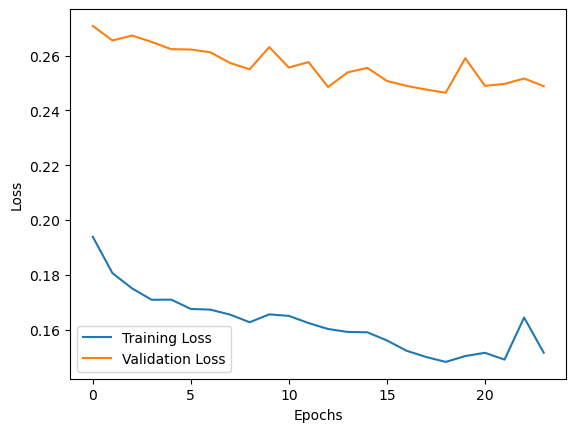

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

For a given user, generate recommendations by reconstructing their ratings.

In [ ]:
def recommend_movies(user_id, user_item_matrix, model, user_id_to_idx, movie_ids, num_recommendations=10):
    # Get the user index
    user_idx = user_id_to_idx[user_id]
    
    # Get the user's ratings
    user_ratings = user_item_matrix.values[user_idx].reshape(1, -1)
    user_ratings_mean = np.mean(user_ratings)
    user_ratings_normalized = user_ratings - user_ratings_mean
    
    # Predict ratings
    reconstructed_ratings = model.predict(user_ratings_normalized)
    reconstructed_ratings = reconstructed_ratings + user_ratings_mean
    
    # Get unrated movies
    unrated_items = np.where(user_ratings.flatten() == 0)[0]
    
    # Get predicted ratings for unrated movies
    predicted_ratings = reconstructed_ratings.flatten()[unrated_items]
    
    # Get top recommendations
    top_indices = unrated_items[np.argsort(predicted_ratings)[::-1][:num_recommendations]]
    recommended_movie_ids = [movie_ids[i] for i in top_indices]
    
    # Get movie titles
    movies_df = pd.read_csv('movies.csv')
    recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]
    
    return recommended_movies[['movieId', 'title', 'genres']]


In [ ]:
user_id = 1  # Replace with a valid user ID
recommended_movies = recommend_movies(user_id, user_item_matrix, autoencoder, user_id_to_idx, movie_ids)
print("Recommended Movies for User ID", user_id)
print(recommended_movies)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Recommended Movies for User ID 1
      movieId                             title                  genres
68         76                  Screamers (1995)  Action|Sci-Fi|Thriller
412       474        In the Line of Fire (1993)         Action|Thriller
455       520  Robin Hood: Men in Tights (1993)                  Comedy
485       553                  Tombstone (1993)    Action|Drama|Western
662       867                    Carpool (1996)            Comedy|Crime
932      1232                    Stalker (1979)    Drama|Mystery|Sci-Fi
2945     3949        Requiem for a Dream (2000)                   Drama
4389     6440                Barton Fink (1991)          Drama|Thriller
6439    51834              Becoming Jane (2007)           Drama|Romance
7171    72011              Up in the Air (2009)           Drama|Romance


Implementing Neural Collaborative Filtering (NCF)

This replaces traditional matrix factorization with neural networks to model non-linear user-item interactions.

In [ ]:
# Binarize ratings: 1 if rating >= 4.0, else 0 to create positive and negative interactions
ratings_df['rating'] = ratings_df['rating'].apply(lambda x: 1 if x >= 4.0 else 0)

# Map user and item IDs to indices
user_ids = ratings_df['userId'].unique().tolist()
movie_ids = ratings_df['movieId'].unique().tolist()
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}


Generate negative interactions for training

In [ ]:
import random
random.seed(42)

def get_negative_samples(ratings, num_negatives):
    user_item_set = set(zip(ratings['userId'], ratings['movieId']))
    all_items = set(movie_ids)
    negative_samples = []
    for user_id in user_ids:
        user_negative_items = all_items - set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
        user_negative_items = random.sample(user_negative_items, num_negatives)
        for item_id in user_negative_items:
            negative_samples.append([user_id, item_id, 0])  # Negative sample
    return negative_samples

# Generate negative samples
negative_samples = get_negative_samples(ratings_df[ratings_df['rating'] == 1], num_negatives=4)


- Positive and Negative Interactions: In recommendation systems, especially those based on implicit feedback, it's common to have mostly positive interactions (e.g., likes or purchases) but very few explicit negative interactions. To address this, negative samples (items that the user has not interacted with) are generated artificially and labeled as negative (interaction value of 0).

- Negative Sampling: For each user, the function randomly selects a fixed number of items (num_negatives) that the user has not interacted with, treating these as negative samples. This helps the model learn the difference between positive interactions (items the user likes) and negative interactions (items the user doesn't engage with).

Possible Improvements:
- Dynamic Number of Negative Samples: Instead of selecting a fixed number of negative samples (e.g., 4), you might want to vary this based on the user's activity. Users with more interactions could have more negative samples, while less active users might need fewer.

- Weighted Sampling: You could improve the sampling process by biasing the selection towards items that are more popular or recently released, as users are more likely to encounter these in practice.

- Negative Sample Filtering: Sometimes, negative samples might include items the user hasn't rated yet but may still like. Additional logic could be added to filter out items that are too similar to the positively rated items (e.g., based on genre or metadata).

- Weighted Sampling: Popular movies are more likely to be selected as negative samples, as users are more likely to encounter these items.
- Efficiency: Since we're using numpy's random.choice with weights, the sampling is efficient even with large numbers of items.
- Recency-based Sampling: This method can be adapted to use movie recency instead of popularity by calculating weights based on how recently the movies were released (e.g., movies released within the last year could get higher weights).

Further Improvements:
- Hybrid Weighting (Popularity + Recency): You can combine both popularity and recency into a single weighting scheme by, for example, multiplying the popularity score by a factor that decays based on the release date of the movie.

- Dynamic num_negatives: You could dynamically adjust the number of negative samples based on the number of positive interactions each user has (more active users may require more negative samples).

- Dynamically Adjusted num_negatives: Users with more positive interactions will receive proportionally more negative samples, while users with fewer interactions will receive fewer negative samples. This approach ensures that more active users (who are likely to have engaged with more content) have a more balanced training set.

- Weighted Sampling Based on Popularity: The negative samples are drawn using a weighted sampling mechanism, giving more popular movies a higher likelihood of being selected as negative samples.

Customizations:
- Recency Weighting: You can adjust the weights to incorporate recency along with popularity by calculating a combined score that includes both the popularity of a movie and how recently it was released.

- User-specific Ratios: Instead of using a fixed neg_to_pos_ratio, you can define different ratios for different groups of users based on their behavior or interaction history.

This approach helps in building a more representative dataset, ensuring that users with high activity levels (more positive interactions) receive an appropriate number of negative samples for training, while also incorporating the popularity of items in the selection process.

Combine Positive and Negative Samples

In [ ]:
positive_samples = ratings_df[ratings_df['rating'] == 1][['userId', 'movieId', 'rating']].values.tolist()
all_samples = positive_samples + negative_samples
all_samples_df = pd.DataFrame(all_samples, columns=['userId', 'movieId', 'rating'])

# Shuffle the data
all_samples_df = all_samples_df.sample(frac=1, random_state=42).reset_index(drop=True)


Split into Training and Test Sets


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(all_samples_df, test_size=0.2, random_state=42)

Defining the NCF Model in Keras


In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Multiply, Concatenate, Dense
from tensorflow.keras.models import Model

num_users = len(user_ids)
num_items = len(movie_ids)
mf_dim = 10  # Dimensionality of the embeddings

# Inputs
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# Embeddings for GMF
user_embedding_gmf = Embedding(num_users, mf_dim, name='user_embedding_gmf')(user_input)
item_embedding_gmf = Embedding(num_items, mf_dim, name='item_embedding_gmf')(item_input)

# Flatten embeddings
user_embedding_gmf = Flatten()(user_embedding_gmf)
item_embedding_gmf = Flatten()(item_embedding_gmf)

# Element-wise multiplication
gmf_vector = Multiply()([user_embedding_gmf, item_embedding_gmf])

# Embeddings for MLP
user_embedding_mlp = Embedding(num_users, mf_dim * 2, name='user_embedding_mlp')(user_input)
item_embedding_mlp = Embedding(num_items, mf_dim * 2, name='item_embedding_mlp')(item_input)

user_embedding_mlp = Flatten()(user_embedding_mlp)
item_embedding_mlp = Flatten()(item_embedding_mlp)

# Concatenate user and item embeddings
mlp_vector = Concatenate()([user_embedding_mlp, item_embedding_mlp])

# MLP layers
mlp_vector = Dense(64, activation='relu')(mlp_vector)
mlp_vector = Dense(32, activation='relu')(mlp_vector)
mlp_vector = Dense(16, activation='relu')(mlp_vector)
mlp_vector = Dense(8, activation='relu')(mlp_vector)

# Concatenate GMF and MLP parts
neuMF_vector = Concatenate()([gmf_vector, mlp_vector])

# Final output layer
prediction = Dense(1, activation='sigmoid', name='prediction')(neuMF_vector)

# Define the model
model = Model(inputs=[user_input, item_input], outputs=prediction)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')


This code implements the NeuMF (Neural Matrix Factorization) model, which is a hybrid recommendation model combining Generalized Matrix Factorization (GMF) and Multi-Layer Perceptron (MLP):

- The GMF branch captures linear interactions between users and items through element-wise multiplication of embeddings.
- The MLP branch captures non-linear, complex interactions between users and items through a series of fully connected layers.
- Both branches are concatenated to form a final interaction vector, which is passed through a sigmoid output layer to predict the probability of a user interacting with an item.

The model is designed for tasks like implicit feedback in recommendation systems, where the goal is to predict whether a user will interact with (e.g., watch, rate, or like) a given item.

Preparing Input Data

In [ ]:
# Map IDs to indices
train_user_indices = train_df['userId'].map(user_id_to_idx).values
train_item_indices = train_df['movieId'].map(movie_id_to_idx).values
train_labels = train_df['rating'].values

test_user_indices = test_df['userId'].map(user_id_to_idx).values
test_item_indices = test_df['movieId'].map(movie_id_to_idx).values
test_labels = test_df['rating'].values


Training the model

In [ ]:
# Define the batch size and epochs
batch_size = 256
epochs = 10

# Train the model
history = model.fit(
    [train_user_indices, train_item_indices],  # Input: user and item indices
    train_labels,  # Output: labels (ratings)
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([test_user_indices, test_item_indices], test_labels),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6901 - val_loss: 0.6707
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6629 - val_loss: 0.6381
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6262 - val_loss: 0.5924
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5727 - val_loss: 0.5251
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4917 - val_loss: 0.4263
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3719 - val_loss: 0.2940
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2211 - val_loss: 0.1561
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0904 - val_loss: 0.0639
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0260 - val_loss: 0.0257
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 0.0127


Evaluating the NCF Model

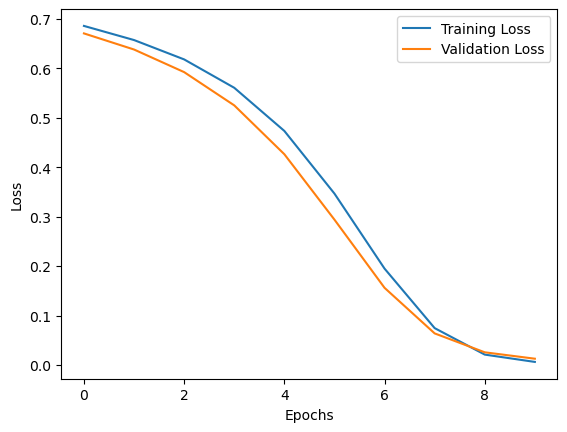

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Generating Recommendations

In [ ]:
def recommend_movies_ncf(user_id, model, user_id_to_idx, movie_id_to_idx, movies_df, num_recommendations=10):
    user_idx = user_id_to_idx[user_id]
    
    # Get items the user hasn't interacted with
    user_rated_items = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    user_rated_item_indices = [movie_id_to_idx[i] for i in user_rated_items]
    all_item_indices = list(movie_id_to_idx.values())
    unrated_item_indices = [i for i in all_item_indices if i not in user_rated_item_indices]
    
    # Prepare input data
    user_indices = np.full(len(unrated_item_indices), user_idx)
    item_indices = np.array(unrated_item_indices)
    
    # Predict scores
    predictions = model.predict([user_indices, item_indices], batch_size=1024).flatten()
    
    # Get top recommendations
    top_indices = predictions.argsort()[::-1][:num_recommendations]
    recommended_item_indices = item_indices[top_indices]
    recommended_movie_ids = [list(movie_id_to_idx.keys())[list(movie_id_to_idx.values()).index(i)] for i in recommended_item_indices]
    
    recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]
    return recommended_movies[['movieId', 'title', 'genres']]


Example Usage

In [ ]:
user_id = 1  # Replace with a valid user ID
movies_df = pd.read_csv('movies.csv')
recommended_movies = recommend_movies_ncf(user_id, model, user_id_to_idx, movie_id_to_idx, movies_df)
print("Recommended Movies for User ID", user_id)
print(recommended_movies)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
Recommended Movies for User ID 1
      movieId                                         title  \
225       261                           Little Women (1994)   
473       540                                 Sliver (1993)   
3039     4067                          Untamed Heart (1993)   
3385     4605        How to Get Ahead in Advertising (1989)   
3896     5472                                   1776 (1972)   
6420    51167  My Father and My Son (Babam ve oglum) (2005)   
7062    69516                 Limits of Control, The (2009)   
8260   104944                          Short Term 12 (2013)   
8454   112303                   Think Like a Man Too (2014)   
9105   144522                               Sky High (2003)   

                      genres  
225                    Drama  
473                 Thriller  
3039           Drama|Romance  
3385          Comedy|Fantasy  
3896  Children|Drama|Musical  
6420                   Drama  
7062   Crime|Dr

Evaluating the Neural Network Model Using AUC

In [ ]:
# Prepare input data for testing
test_user_indices = test_df['userId'].map(user_id_to_idx).values
test_item_indices = test_df['movieId'].map(movie_id_to_idx).values
test_labels = test_df['rating'].values

Use the trained NCF model to make predictions on the test set:

In [ ]:
# Make predictions
test_predictions = model.predict([test_user_indices, test_item_indices], batch_size=1024).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Now let's modify the get_user_recommendations() function to use the neural network model (Neural Collaborative Filtering (NCF) implemented with TensorFlow/Keras) instead of the SVD model

The function will:

- Use the neural network model for collaborative filtering predictions.
- Integrate content-based filtering as before.
- Combine both methods to generate hybrid recommendations.
- Provide explanations for the recommendations.

In [ ]:
def get_user_recommendations(user_id=None, num_recommendations=10, preferred_genres=None, preferred_tags=None):
    """
    Generate personalized movie recommendations for a given user or based on preferred genres/tags.

    Parameters:
    - user_id (int, optional): The ID of the user. If None, recommendations will be based on preferred genres/tags.
    - num_recommendations (int): The number of recommendations to return.
    - preferred_genres (list, optional): A list of preferred genres.
    - preferred_tags (list, optional): A list of preferred tags.

    Returns:
    - recommendations_df (DataFrame): A DataFrame containing the recommended movies,
      their hybrid scores, and explanations.
    """
    # Validate inputs
    if user_id is not None and user_id not in ratings_df['userId'].unique():
        print(f"User ID {user_id} not found. Recommendations will be based on preferred genres/tags.")
        user_id = None

    # Initialize variables
    all_movie_ids = movies_df['movieId'].unique()

    # Movies the user has already rated
    if user_id is not None:
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        rated_movies = user_ratings['movieId'].tolist()
    else:
        user_ratings = pd.DataFrame()
        rated_movies = []

    # Movies the user hasn't rated yet
    unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

    # Collaborative Filtering Predictions using Neural Network Model
    if user_id is not None and not user_ratings.empty:
        # Map user_id to user_idx
        if user_id in user_id_to_idx:
            user_idx = user_id_to_idx[user_id]
        else:
            print(f"User ID {user_id} not found in neural network model.")
            return None

        # Map movie IDs to item indices
        unrated_movie_indices = []
        valid_movie_ids = []
        for movie_id in unrated_movies:
            if movie_id in movie_id_to_idx:
                item_idx = movie_id_to_idx[movie_id]
                unrated_movie_indices.append(item_idx)
                valid_movie_ids.append(movie_id)

        # Prepare input arrays
        user_indices = np.full(len(unrated_movie_indices), user_idx)
        item_indices = np.array(unrated_movie_indices)

        # Make predictions using the neural network model
        cf_scores = model.predict([user_indices, item_indices], batch_size=1024).flatten()

        # Create DataFrame of predictions
        cf_pred_df = pd.DataFrame({'movieId': valid_movie_ids, 'cf_score': cf_scores})
    else:
        cf_pred_df = pd.DataFrame(columns=['movieId', 'cf_score'])

    # Content-Based Filtering Scores
    # Build user profile vector based on preferences
    # If user has ratings, combine their profile with preferred genres/tags
    if not user_ratings.empty:
        # Build profile from rated movies
        user_movies = pd.merge(user_ratings, movies_with_tags, on='movieId', how='left')
        user_profile_tfidf = np.zeros(tfidf_matrix.shape[1])
        for idx, row in user_movies.iterrows():
            movie_idx = movies_with_tags.index[movies_with_tags['movieId'] == row['movieId']][0]
            movie_tfidf = tfidf_matrix[movie_idx].toarray().flatten()
            user_profile_tfidf += movie_tfidf * row['rating']
    else:
        user_profile_tfidf = np.zeros(tfidf_matrix.shape[1])

    # Incorporate preferred genres and tags
    preference_text = ''
    if preferred_genres:
        preference_text += ' '.join(preferred_genres) + ' '
    if preferred_tags:
        preference_text += ' '.join(preferred_tags)
    preference_text = preprocess(preference_text)

    if preference_text:
        # Transform preference text into TF-IDF vector
        preference_vector = tfidf.transform([preference_text]).toarray().flatten()
        # Combine with user profile
        user_profile_tfidf += preference_vector * 2  # Weight preferences more heavily
    else:
        if user_profile_tfidf.sum() == 0:
            print("No user ratings or preferences provided. Cannot generate recommendations.")
            return None

    # Normalize the user profile vector
    if np.linalg.norm(user_profile_tfidf) == 0:
        user_profile_tfidf_normalized = user_profile_tfidf
    else:
        user_profile_tfidf_normalized = user_profile_tfidf / np.linalg.norm(user_profile_tfidf)

    # Compute cosine similarity between user profile and all movie vectors
    content_similarities = cosine_similarity([user_profile_tfidf_normalized], tfidf_matrix).flatten()

    # Create content-based predictions for unrated movies
    cb_predictions = []
    for idx, movie_id in enumerate(movies_with_tags['movieId']):
        if movie_id in unrated_movies:
            cb_predictions.append((movie_id, content_similarities[idx]))
    cb_pred_df = pd.DataFrame(cb_predictions, columns=['movieId', 'cb_score'])

    # Merge predictions
    if not cf_pred_df.empty:
        hybrid_pred_df = pd.merge(cf_pred_df, cb_pred_df, on='movieId', how='inner')
    else:
        hybrid_pred_df = cb_pred_df.copy()
        hybrid_pred_df['cf_score'] = np.nan  # Placeholder for consistency

    # Calculate weights
    if user_id is not None and not user_ratings.empty:
        num_user_ratings = len(user_ratings)
        max_ratings = ratings_df['userId'].value_counts().max()
        cf_weight = num_user_ratings / max_ratings
        cb_weight = 1 - cf_weight
        # Ensure weights sum to 1
        cf_weight = cf_weight / (cf_weight + cb_weight)
        cb_weight = 1 - cf_weight
    else:
        cf_weight = 0.0
        cb_weight = 1.0

    # Compute hybrid score
    hybrid_pred_df['hybrid_score'] = (cf_weight * hybrid_pred_df['cf_score'].fillna(0)) + (cb_weight * hybrid_pred_df['cb_score'])

    # Merge with movies DataFrame to get titles and genres
    hybrid_pred_df = pd.merge(hybrid_pred_df, movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

    # Sort by hybrid score
    hybrid_pred_df = hybrid_pred_df.sort_values(by='hybrid_score', ascending=False)

    # Select the top N recommendations
    top_recommendations = hybrid_pred_df.head(num_recommendations)

    # Generate explanations
    explanations = []
    for idx, row in top_recommendations.iterrows():
        explanation = ""
        # High predicted rating
        if not np.isnan(row['cf_score']) and row['cf_score'] >= 0.5:
            explanation += "High predicted preference score. "
        # Matching genres
        movie_genres = set(row['genres'].split('|'))
        matching_genres = set(preferred_genres or []) & movie_genres
        if matching_genres:
            explanation += f"Includes your preferred genres: {', '.join(matching_genres)}. "
        # Similar content
        if row['cb_score'] >= 0.5:
            explanation += "Similar content based on your preferences. "
        explanations.append(explanation.strip())

    # Add explanations to the DataFrame
    top_recommendations['explanation'] = explanations

    # Reorder columns
    recommendations_df = top_recommendations[['movieId', 'title', 'hybrid_score', 'explanation']]

    return recommendations_df.reset_index(drop=True)


In [ ]:
# Example usage
user_id = 1  # Replace with the target user ID
preferred_genres = ['Action', 'Adventure']
preferred_tags = ['space', 'future']
num_recommendations = 5

recommendations = get_user_recommendations(
    user_id=user_id,
    num_recommendations=num_recommendations,
    preferred_genres=preferred_genres,
    preferred_tags=preferred_tags
)

print("Personalized Recommendations:")
print(recommendations)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
Personalized Recommendations:
   movieId                                 title  hybrid_score  \
0      924          2001: A Space Odyssey (1968)      0.502495   
1      541                   Blade Runner (1982)      0.502477   
2    68358                      Star Trek (2009)      0.502455   
3   174053  Black Mirror: White Christmas (2014)      0.502331   
4     5445                Minority Report (2002)      0.502190   

                                         explanation  
0  Includes your preferred genres: Adventure. Sim...  
1  Includes your preferred genres: Action. Simila...  
2  Includes your preferred genres: Action, Advent...  
3         Similar content based on your preferences.  
4  Includes your preferred genres: Action. Simila...  


Extracting Valid Genres

In [ ]:
unique_genres = set()
for genres_list in movies_df['genres']:
    unique_genres.update(genres_list)

# Convert the set to a sorted list
unique_genres = sorted(unique_genres)

print("Available Genres:")
print(unique_genres)


Available Genres:
[' ', '(', ')', '-', 'A', 'C', 'D', 'F', 'H', 'I', 'M', 'N', 'R', 'S', 'T', 'W', 'X', 'a', 'c', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'r', 's', 't', 'u', 'v', 'y', '|']


In [ ]:
len(unique_genres)

35

Extracting valid tags

In [ ]:
# Fill NaN values in 'tag' column with empty strings
tags_df['tag'] = tags_df['tag'].fillna('')

# Convert tags to lowercase and strip whitespace
tags_df['tag'] = tags_df['tag'].str.lower().str.strip()

# Remove empty strings
tags_df = tags_df[tags_df['tag'] != '']

# Get unique tags
unique_tags = tags_df['tag'].unique()

# Convert to a list and sort
unique_tags = sorted(unique_tags)

print("Available Tags:")
print(unique_tags)


Available Tags:
['"artsy"', '06 oscar nominated best movie - animation', '1900s', '1920s', '1950s', '1960s', '1970s', '1980s', '1990s', '2001-like', '2d animation', '70mm', "80's", 'a clever chef rat', 'a dingo ate my baby', 'aardman', 'abortion', 'absorbing', 'abstract', 'academy award (best supporting actress)', 'accident', 'achronological', 'acting', 'action', 'action choreography', 'action packed', 'adam sandler', 'addiction', 'adolescence', 'adoption', 'adorable', 'adrien brody', 'adult humor', 'adultery', 'adventure', 'afghanistan', 'africa', 'agatha christie', 'aggressive', 'aging', 'aids', 'al pacino', 'alan rickman', 'alcatraz', 'alcoholism', 'alfred hitchcock', 'alicia vikander', 'aliens', 'allegorical', 'alone in the world', 'alter ego', 'alternate endings', 'alternate reality', 'alternate universe', 'amazing', 'amazing artwork', 'amazing cinematography', 'amazing dialogues', 'american idolatry', 'american indians', 'american propaganda', 'amish', 'amnesia', 'amtrak', 'amy a

In [ ]:
len(unique_tags)

1475

The available tags are numerous and sometimes overlapping or redundant, making it difficult for users to select from them.

We can use NLP to analyze the tags and group them into meaningful categories or clusters, resulting in a condensed list of tags that users can easily select from.

We will:

1. Preprocess the Tags: Clean and normalize the tags for consistent processing.
2. Represent Tags Using Word Embeddings: Convert tags into numerical vectors that capture semantic meaning.
3. Cluster Similar Tags: Group tags based on their semantic similarity.
4. Generate Condensed Tag List: Select representative tags or create labels for each cluster.
5. Present the Condensed List: Provide the condensed list to the user.

Preprocessing the Tags
- Convert to Lowercase: Ensure all tags are in lowercase.
- Remove Punctuation: Clean tags of any punctuation.
- Tokenization: Split multi-word tags into individual words.
- Lemmatization: Reduce words to their base form.
- Remove Stopwords: Eliminate common words that don't add meaning.


In [ ]:
import nltk
import string
import pandas as pd
import numpy as np
import gensim.downloader as api
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Sample list of tags (replace this with your actual list)
tags_list = unique_tags

# Preprocess tags
def preprocess_tag(tag):
    # Remove punctuation
    tag = tag.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    tag = tag.lower()
    # Tokenize
    tokens = word_tokenize(tag)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Rejoin tokens
    preprocessed_tag = ' '.join(tokens)
    return preprocessed_tag

preprocessed_tags = [preprocess_tag(tag) for tag in tags_list]


[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Represent Tags Using Word Embeddings
- We will use pre-trained word embeddings from Gensim's word2vec-google-news-300 model to represent each tag as a vector.

- Handle Multi-word Tags: For tags with multiple words, we'll compute the average of the word vectors.

In [ ]:
# Load pre-trained word2vec model (this may take a few minutes and requires internet access)
model = api.load('word2vec-google-news-300')  # 300-dimensional vectors

# Function to get vector for a tag
def get_tag_vector(tag):
    tokens = tag.split()
    vectors = []
    for token in tokens:
        if token in model:
            vectors.append(model[token])
    if vectors:
        # Compute average vector
        tag_vector = np.mean(vectors, axis=0)
        return tag_vector
    else:
        # If none of the words are in the model, return a zero vector
        return np.zeros(model.vector_size)

# Get vectors for all tags
tag_vectors = []
valid_tags = []
for tag in preprocessed_tags:
    vector = get_tag_vector(tag)
    if np.any(vector):
        tag_vectors.append(vector)
        valid_tags.append(tag)
    else:
        # Skip tags that cannot be vectorized
        pass

# Convert list to numpy array
tag_vectors = np.array(tag_vectors)


Clustering Similar Tags
- We'll use Agglomerative Hierarchical Clustering to cluster the tags based on their semantic similarity.

In [ ]:
# Clustering Similar Tags
from sklearn.cluster import AgglomerativeClustering

# Decide on the number of clusters (adjust as needed)
num_clusters = 50

# Perform clustering
clustering_model = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric='euclidean',
    linkage='ward'
)
clustering_model.fit(tag_vectors)

# Get cluster labels
labels = clustering_model.labels_

# Create a DataFrame to hold tags and their cluster labels
tag_cluster_df = pd.DataFrame({'tag': valid_tags, 'cluster': labels})

print(f"Number of clusters formed: {len(set(labels))}")


Number of clusters formed: 50


Generating Condensed Tag List
- We'll select a representative tag for each cluster by finding the tag closest to the cluster centroid.

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

# Initialize list to store representative tags
condensed_tags = []

for cluster_num in range(num_clusters):
    # Get all tags in this cluster
    cluster_tags = tag_cluster_df[tag_cluster_df['cluster'] == cluster_num]
    indices = cluster_tags.index
    cluster_vectors = tag_vectors[indices]
    
    # Compute the centroid of the cluster
    centroid = np.mean(cluster_vectors, axis=0)
    
    # Calculate distances from each tag vector to the centroid
    distances = cosine_distances(cluster_vectors, [centroid]).flatten()
    
    # Find the index of the tag closest to the centroid
    closest_index = distances.argmin()
    representative_tag = cluster_tags.iloc[closest_index]['tag']
    
    condensed_tags.append(representative_tag)


Presenting the Condensed List
- Displaying the Condensed Tag List

In [ ]:
# Sort the condensed tags alphabetically
condensed_tags_sorted = sorted(condensed_tags)

print("Condensed Tag List:")
for tag in condensed_tags_sorted:
    print(tag)


Condensed Tag List:
beautiful cinematography
beautiful visuals
boxing
bubba gump shrimp
casino
child
classic movie
classic scifi
cliche character
comedy
computer animation
crime
dance
dark fairy tale
depression
dialogue
dinosaur
drug
europe
gangster
gun
humor
interracial romance
kevin smith
kidnapping
lawyer
melancholic
morality
nerd
nonlinear narrative
ocean
parenthood
philip seymour hoffman
poignant
priest
rich guy poor girl
robot android
rstrong bloody violence
ryan reynolds
sex
something everyone one saw without plan seeing kid
spying
stephen king
strange
stupid funny
tragedy
train
vampire
war
wedding


In [ ]:
len(condensed_tags_sorted)

50

In [ ]:
print("\nClusters and Their Tags:")
for cluster_num in range(num_clusters):
    cluster_tags = tag_cluster_df[tag_cluster_df['cluster'] == cluster_num]['tag'].tolist()
    representative_tag = condensed_tags[cluster_num]
    print(f"Cluster {cluster_num}: Representative Tag - '{representative_tag}'")
    print(f"Tags: {', '.join(cluster_tags)}\n")



Clusters and Their Tags:
Cluster 0: Representative Tag - 'philip seymour hoffman'
Tags: agatha christie, al pacino, alfred hitchcock, alicia vikander, american idolatry, american indian, american propaganda, ancient rome, arnold schwarzenegger, beatles, ben affleck, ben kingsley, bill murray, borg, british, british comedy, british gangster, broadway, cameowhoopi goldberg, cate blanchett, charlotte bronte, christian bale, christmas, cia, dan aykroyd, day hudson, dc, disney, doc ock, dorothy, email, e forster, einstein, eugene oneill, eva green, fbi, hal, halle berry, halloween, harley quinn, harley quinns as, hawkeye, hollywood, netflix queue, jaime pressly, jay silent bob, jeff bridge, jekyll hyde, jessica alba, johnny cash, johnny depp, kung fu, la, la vega, leonardo dicaprio, leonardo dicarpio, lieutenant dan, los angeles, luc besson, matt damon, mcu, mila kunis, moses, nasa, natalie portman, native american, new york, new york city, nick nora charles, dvd netflix, norman bates, ava

Using contextual embeddings like BERT can capture the semantic meaning of tags more effectively than traditional word embeddings. This can lead to more accurate clustering and a condensed tag list that makes sense.

Preprocess the Tags

We'll start by preprocessing the tags to ensure consistency.

In [ ]:
import nltk
import string
import pandas as pd
import numpy as np

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Your list of unique tags (ensure 'unique_tags' is defined with your tags)
tags_list = unique_tags  # Replace 'unique_tags' with your actual list

# Preprocess tags
def preprocess_tag(tag):
    # Remove punctuation
    tag = tag.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    tag = tag.lower()
    # Tokenize
    tokens = word_tokenize(tag)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Rejoin tokens
    preprocessed_tag = ' '.join(tokens)
    return preprocessed_tag

preprocessed_tags = [preprocess_tag(tag) for tag in tags_list]


[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Generate BERT Embeddings for Tags

We'll use the pre-trained BERT model from Hugging Face's transformers library to generate embeddings.

Load BERT Model

We'll use the sentence-transformers library, which simplifies obtaining embeddings for sentences or phrases using BERT.

In [ ]:
from sentence_transformers import SentenceTransformer

# Load the pre-trained BERT model (this may take some time)
model = SentenceTransformer('all-MiniLM-L6-v2')  # A smaller, efficient model


Generate Embeddings

In [ ]:
# Generate embeddings for all preprocessed tags
tag_embeddings = model.encode(preprocessed_tags)


Cluster Similar Tags

- We'll use Agglomerative Hierarchical Clustering to cluster the tag embeddings.


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Decide on the number of clusters (adjust as needed)
num_clusters = 50

# Perform clustering
clustering_model = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric='euclidean',
    linkage='ward'
)
clustering_model.fit(tag_embeddings)

# Get cluster labels
labels = clustering_model.labels_

# Create a DataFrame to hold tags and their cluster labels
tag_cluster_df = pd.DataFrame({'tag': preprocessed_tags, 'cluster': labels})

print(f"Number of clusters formed: {len(set(labels))}")


Number of clusters formed: 50


Generate Condensed Tag List
- We'll select a representative tag for each cluster.

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

# Initialize list to store representative tags
condensed_tags = []

for cluster_num in range(num_clusters):
    # Get all tags in this cluster
    cluster_tags = tag_cluster_df[tag_cluster_df['cluster'] == cluster_num]
    indices = cluster_tags.index
    cluster_vectors = tag_embeddings[indices]
    
    # Compute the centroid of the cluster
    centroid = np.mean(cluster_vectors, axis=0)
    
    # Calculate distances from each tag vector to the centroid
    distances = cosine_distances(cluster_vectors, [centroid]).flatten()
    
    # Find the index of the tag closest to the centroid
    closest_index = distances.argmin()
    representative_tag = cluster_tags.iloc[closest_index]['tag']
    
    condensed_tags.append(representative_tag)


Display the Condensed Tag List

In [ ]:
# Sort the condensed tags alphabetically
condensed_tags_sorted = sorted(condensed_tags)

print("Condensed Tag List:")
for tag in condensed_tags_sorted:
    print(tag)


Condensed Tag List:
1980s
acting
amazing
artistic
australia
bad story
business
cartoon
character
comedy
crime
dialogue
drug
emma thompson
ending
fairy tale
food
funny
gold
gunfight
horror
imagination
james cameron
killer
lawyer
marion cotillard
movie movie
multiple story
music
nonlinear timeline
oscar best actress
parenthood
philosophical
poetic
poor plot development
priest
racism
romance
scifi masterpiece
scott turow
sentimental
singer
space
sport
stylish
superhero
twist
violence
war
whale


Display Clusters and Their Tags

In [ ]:
print("\nClusters and Their Tags:")
for cluster_num in range(num_clusters):
    cluster_tags_list = tag_cluster_df[tag_cluster_df['cluster'] == cluster_num]['tag'].tolist()
    representative_tag = condensed_tags[cluster_num]
    print(f"Cluster {cluster_num}: Representative Tag - '{representative_tag}'")
    print(f"Tags: {', '.join(cluster_tags_list)}\n")



Clusters and Their Tags:
Cluster 0: Representative Tag - 'funny'
Tags: annoying, bizarre, clever, crazy, dumb, funny, genius, hilarious, humorous, insane, insanity, insightful, interesting, interesting scenario, ironic, irony, nonsense, funny, parody, ridiculous, sarcasm, satire, satirical, silly, strange, stupid, stupid funny, stupid stupid, unconventional, unusual, funny, weird, witty

Cluster 1: Representative Tag - 'philosophical'
Tags: abstract, achronological, allegorical, american propaganda, antiintellectual, antisemitism, antiwar, consumerism, contemplative, dystopia, ethic, existential, existentialism, fighting system, free speech, freedom, freedom expression, genocide, holocaust, human right, humane, individualism, inhumane, journalism, mediacentralism, metaphorical, morality, motivational, nazi, new society, philosophical, philosophical issue, philosophy, philosopical, political commentary, political right versus left, psychological, psychology, purposefulness, r language,

Additional Considerations
Adjusting Clustering Parameters: If the condensed tag list doesn't make sense, try adjusting num_clusters or using different clustering algorithms (e.g., KMeans, DBSCAN).
Semantic Cohesion: Use metrics like Silhouette Score to evaluate the quality of the clusters.
Interactive Visualization: Tools like t-SNE or UMAP can help visualize high-dimensional embeddings in 2D space for inspection.

Final Thoughts

By using BERT embeddings, we've improved the semantic representation of tags, leading to more meaningful clustering and a condensed tag list that makes sense. This list can enhance the user experience by simplifying the selection of tags for personalized recommendations.



Updated get_user_recommendations Function

In [ ]:
def get_user_recommendations(user_id=None, num_recommendations=10, preferred_genres=None, preferred_tags=None):
    """
    Generate personalized movie recommendations for a given user or based on preferred genres/tags.

    Parameters:
    - user_id (int, optional): The ID of the user. If None, recommendations will be based on preferred genres/tags.
    - num_recommendations (int): The number of recommendations to return.
    - preferred_genres (list, optional): A list of preferred genres.
    - preferred_tags (list, optional): A list of preferred tags.

    Returns:
    - recommendations_df (DataFrame): A DataFrame containing the recommended movies,
      their hybrid scores, and explanations.
    """
    # Validate inputs
    if user_id is not None and user_id not in ratings_df['userId'].unique():
        print(f"User ID {user_id} not found. Recommendations will be based on preferred genres/tags.")
        user_id = None

    # Initialize variables
    all_movie_ids = movies_df['movieId'].unique()

    # Movies the user has already rated
    if user_id is not None:
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        rated_movies = user_ratings['movieId'].tolist()
    else:
        user_ratings = pd.DataFrame()
        rated_movies = []

    # Movies the user hasn't rated yet
    unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

    # Collaborative Filtering Predictions using Neural Network Model
    if user_id is not None and not user_ratings.empty:
        # Map user_id to user_idx
        if user_id in user_id_to_idx:
            user_idx = user_id_to_idx[user_id]
        else:
            print(f"User ID {user_id} not found in neural network model.")
            return None

        # Map movie IDs to item indices
        unrated_movie_indices = []
        valid_movie_ids = []
        for movie_id in unrated_movies:
            if movie_id in movie_id_to_idx:
                item_idx = movie_id_to_idx[movie_id]
                unrated_movie_indices.append(item_idx)
                valid_movie_ids.append(movie_id)

        # Prepare input arrays
        user_indices = np.full(len(unrated_movie_indices), user_idx)
        item_indices = np.array(unrated_movie_indices)

        # Make predictions using the neural network model
        cf_scores = model.predict([user_indices, item_indices], batch_size=1024).flatten()

        # Create DataFrame of predictions
        cf_pred_df = pd.DataFrame({'movieId': valid_movie_ids, 'cf_score': cf_scores})
    else:
        cf_pred_df = pd.DataFrame(columns=['movieId', 'cf_score'])

    # Content-Based Filtering Scores
    # Build user profile vector based on preferences
    # If user has ratings, combine their profile with preferred genres/tags
    user_profile_tfidf = np.zeros(tfidf_matrix.shape[1])

    # Incorporate preferred genres and tags
    preference_text = ''
    if preferred_genres:
        # Ensure genres are in the unique genres list
        valid_genres = [genre for genre in preferred_genres if genre in unique_genres]
        preference_text += ' '.join(valid_genres) + ' '
    if preferred_tags:
        # Ensure tags are in the condensed tags list
        valid_tags = [tag for tag in preferred_tags if tag in condensed_tags]
        preference_text += ' '.join(valid_tags)
    preference_text = preprocess(preference_text)

    if preference_text:
        # Transform preference text into TF-IDF vector
        preference_vector = tfidf.transform([preference_text]).toarray().flatten()
        # Combine with user profile
        user_profile_tfidf += preference_vector * 2  # Weight preferences more heavily
    else:
        if user_profile_tfidf.sum() == 0:
            print("No user ratings or valid preferences provided. Cannot generate recommendations.")
            return None

    # Normalize the user profile vector
    if np.linalg.norm(user_profile_tfidf) == 0:
        user_profile_tfidf_normalized = user_profile_tfidf
    else:
        user_profile_tfidf_normalized = user_profile_tfidf / np.linalg.norm(user_profile_tfidf)

    # Compute cosine similarity between user profile and all movie vectors
    content_similarities = cosine_similarity([user_profile_tfidf_normalized], tfidf_matrix).flatten()

    # Create content-based predictions for unrated movies
    cb_predictions = []
    for idx, movie_id in enumerate(movies_with_tags['movieId']):
        if movie_id in unrated_movies:
            cb_predictions.append((movie_id, content_similarities[idx]))
    cb_pred_df = pd.DataFrame(cb_predictions, columns=['movieId', 'cb_score'])

    # Merge predictions
    if not cf_pred_df.empty:
        hybrid_pred_df = pd.merge(cf_pred_df, cb_pred_df, on='movieId', how='inner')
    else:
        hybrid_pred_df = cb_pred_df.copy()
        hybrid_pred_df['cf_score'] = np.nan  # Placeholder for consistency

    # Calculate weights
    if user_id is not None and not user_ratings.empty:
        num_user_ratings = len(user_ratings)
        max_ratings = ratings_df['userId'].value_counts().max()
        cf_weight = num_user_ratings / max_ratings
        cb_weight = 1 - cf_weight
        # Ensure weights sum to 1
        cf_weight = cf_weight / (cf_weight + cb_weight)
        cb_weight = 1 - cf_weight
    else:
        cf_weight = 0.0
        cb_weight = 1.0

    # Compute hybrid score
    hybrid_pred_df['hybrid_score'] = (cf_weight * hybrid_pred_df['cf_score'].fillna(0)) + (cb_weight * hybrid_pred_df['cb_score'])

    # Merge with movies DataFrame to get titles and genres
    hybrid_pred_df = pd.merge(hybrid_pred_df, movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

    # Sort by hybrid score
    hybrid_pred_df = hybrid_pred_df.sort_values(by='hybrid_score', ascending=False)

    # Select the top N recommendations
    top_recommendations = hybrid_pred_df.head(num_recommendations)

    # Generate explanations
    explanations = []
    for idx, row in top_recommendations.iterrows():
        explanation = ""
        # High predicted preference score
        if not np.isnan(row['cf_score']) and row['cf_score'] >= 0.5:
            explanation += "High predicted preference score. "
        # Matching genres
        movie_genres = set(row['genres'])
        matching_genres = set(preferred_genres or []) & movie_genres
        if matching_genres:
            explanation += f"Includes your preferred genres: {', '.join(matching_genres)}. "
        # Similar content
        if row['cb_score'] >= 0.5:
            explanation += "Similar content based on your preferences. "
        explanations.append(explanation.strip())

    # Add explanations to the DataFrame
    top_recommendations['explanation'] = explanations

    # Reorder columns
    recommendations_df = top_recommendations[['movieId', 'title', 'hybrid_score', 'explanation']]

    return recommendations_df.reset_index(drop=True)


In [ ]:
condensed_tags

['funny',
 'philosophical',
 'romance',
 'scifi masterpiece',
 'priest',
 'scott turow',
 'marion cotillard',
 '1980s',
 'drug',
 'sentimental',
 'whale',
 'parenthood',
 'crime',
 'comedy',
 'artistic',
 'imagination',
 'australia',
 'business',
 'food',
 'gold',
 'acting',
 'poetic',
 'gunfight',
 'fairy tale',
 'multiple story',
 'superhero',
 'poor plot development',
 'ending',
 'horror',
 'sport',
 'amazing',
 'music',
 'war',
 'violence',
 'bad story',
 'nonlinear timeline',
 'cartoon',
 'dialogue',
 'racism',
 'twist',
 'singer',
 'james cameron',
 'oscar best actress',
 'killer',
 'space',
 'movie movie',
 'stylish',
 'character',
 'emma thompson',
 'lawyer']

In [ ]:
# Example usage
preferred_genres = ['Romance', 'Action']  # User-selected genres
preferred_tags = ['comedy']     # User-selected tags from condensed_tags
num_recommendations = 10

recommendations = get_user_recommendations(
    user_id=None,  # or specify a user_id if available
    num_recommendations=num_recommendations,
    preferred_genres=preferred_genres,
    preferred_tags=preferred_tags
)

print("Recommendations Based on Your Preferences:")
print(recommendations)

Recommendations Based on Your Preferences:
   movieId                                         title  hybrid_score  \
0    69122                          Hangover, The (2009)           1.0   
1   193565                     Gintama: The Movie (2010)           1.0   
2     1732                      Big Lebowski, The (1998)           1.0   
3      296                           Pulp Fiction (1994)           1.0   
4    85565                            Chalet Girl (2011)           1.0   
5   183611                             Game Night (2018)           1.0   
6      413                               Airheads (1994)           1.0   
7    67087                        I Love You, Man (2009)           1.0   
8     4816                              Zoolander (2001)           1.0   
9     8641  Anchorman: The Legend of Ron Burgundy (2004)           1.0   

                                  explanation  
0  Similar content based on your preferences.  
1  Similar content based on your preferences. 

Conclusion
By incorporating the unique genres and the condensed tags into the get_user_recommendations function, we've enhanced its ability to generate personalized movie recommendations based on the user's specified interests. The function now:

Validates and uses the user's preferred genres and tags.
Combines collaborative filtering (if user ratings are available) with content-based filtering.
Provides explanations for each recommendation, improving transparency and user trust.